This notebook covers the runs with three polystyrene (DVB-crosslinked) particles and one polyethylene particle. 

In [1]:

import numpy as np
import pprint
import math
import matplotlib
import matplotlib.pyplot as plt
from glob import glob
import re
from re import split


Let's set some variables:

In [2]:
mlen = 3 # number states to transition to/from
tlen = 3 # number of ways to measure transition time 
            #-> Either by length of time stable, length of time spent transitioning, or both combined

excludedvids=[] # videos which, due to errors in data collection, should not be used

sttr = '\[*list' # the correct separator for the text as it's formatted currently

And define some functions:

In [3]:
def parser_arr_old(filename):
    # returns array of all traansitions and list of all class and transition thresholds
    transitions = []
    thresholds = []
    vidarrs = []
    with open(filename) as textfile:
        line = textfile.readline()
        while line:
            if 'Processing' in line:
                vidnum = line.split('pp_')[-1]
                vidnum = vidnum.split('.avi')[0]
                vidnum = vidnum.split('_')[0]
                vidnum = int(vidnum)
                line = textfile.readline()
            if 'T threshold'in line:
                thresh_set = []
                for word in line.split():
                    try:
                        thresh_set.append(float(word))
                    except ValueError:
                        pass
                    
                line = textfile.readline()
                if 'C threshold' in line:
                    for word in line.split():
                        try:
                            thresh_set.append(float(word))
                        except ValueError:
                            pass
                                        
                    if len(thresholds) ==0 or thresholds[-1] != thresh_set:
                        thresholds.append(thresh_set)
                        vidnums=[]
                        vidarrs.append([[], vidnums])
                    else:
                        pass    
                    
                    line = textfile.readline()
                    if '[[' in line:
                        arr = np.zeros((mlen,mlen))
                        linenums = [int(s) for s in  re.findall(r'\d+',line)]
                        arr[0,:] = linenums

                        line = textfile.readline()  

                        linenums = [int(s) for s in  re.findall(r'\d+',line)]
                        arr[1,:] = linenums

                        vidarrs[-1][0].append(arr)
                        vidarrs[-1][1].append(vidnum)
                    else:
                        print("missing array")
                else:
                    print("missing C thresh")
                
                
                    
            line = textfile.readline()
                    
                
            
    textfile.close()
    return([np.array(thresholds), vidarrs]) 

In [4]:
def end_append(times1, times2):
    # list of two triplets of times
    times = np.empty(np.shape(times1), dtype=object)
    #smash the triplets together at the end
    for ind, timepair in enumerate(zip(times1, times2)):
        times[ind] = array_smash(timepair) 
    return(times)

def array_smash(timepair):
    # take two times, ie two sets of three rrows, three colums, each column of which is a list of videos's lists of times
    # and return three rows, 3 columns, each column being a combination of the previous 2
    time1, time2 = timepair
    rlen = len(time1)
    clen = len(time1[0])
    new_time_array = np.empty((rlen,clen), dtype = object)
    rinds = range(rlen)
    cinds = range(clen)
    for r in rinds:
        for c in cinds:
            new_time_array[r, c] = np.concatenate((time1[r,c], time2[r,c]))
    return(new_time_array)
            
# get min, max of an array
def minmax(arr):
    return (np.min(arr), np.max(arr))

# Plot the graphs 
def plotter(xs, yls, cols, xlabel): 
    fig,ax = plt.subplots()  
    ranges = []
    for index, y in enumerate(yls):
        plt.plot(xs, y, c = cols[index], ls = '-', label = labels[index], marker = "^")
        ran = minmax(y)
        plt.axhline(y=ran[0], c = cols[index], ls = ':')
        plt.axhline(y=ran[1], c = cols[index], ls = ':')
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel('observed probability of transition', fontsize=16)
    ax.legend(loc = 'center right', framealpha = 0.3)
    
# Plot the graphs 
def eig_plotter(xs, yls, cols, xlabel, rangeys): 
    fig,ax = plt.subplots()  
    ranges = []
    for index, y in enumerate(yls):
        plt.plot(xs, y, c = cols[index], ls = '-', label = labels[index])
        ran = minmax(rangeys[index])
        plt.axhline(y=ran[0], c = cols[index], ls = ':')
        plt.axhline(y=ran[1], c = cols[index], ls = ':')
    plt.plot((1, 1,1),(100/6,100/6,400/6), 'o')
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel('predicted probability of transition', fontsize=16)
    ax.legend(loc = 'center right', framealpha = 0.3)


# Euclidean distance between two vectors
def vector_dist(v1, v2): # euclidean distance between 2 points
    return math.sqrt(np.sum([(v1[i] - v2[i])**2 for i in range(len(v1))]))

# Divide a row through by its sum
# Used for normalising rows in matrices, which might sum to zero (have no transitions)
def ratio(row):
    sums = np.sum(row)
    if sums > 0:
        return row/sums
    else:
        return row

# Divide all columns through by their sums
def col_norm(array):
    cols = array.T
    cols = np.array([ratio(j)*100 for j in cols])
    return cols.T

# Divide all rows through by their sums
def row_norm(array):
    rows = np.array([ratio(j)*100 for j in array])
    return rows

# Flatten an array of lists 
def flattener(array_of_lists):
    return(np.array([x for y in array_of_lists for x in y]))

#read data from its text file
def parser_arr(filename): 
    # returns arrays of all transitions, transition times, and list of all class and transition thresholds
    transitions = []
    thresholds = []
    vidarrs = []
    statecounts = []
    with open(filename) as textfile:
        line = textfile.readline()
        while line:
            if 'Processing' in line: # collect the video number from the text
                vidnum = line.split('pp_')[-1]
                vidnum = vidnum.split('.avi')[0]
                vidnum = vidnum.split('_')[0]
                vidnum = int(vidnum)
                line = textfile.readline()
                
            #collect transition and stability thresholds
            if 'T threshold'in line:                 
                thresh_set = []
                
                # colect stability threshold
                for word in line.split():
                    try:
                        thresh_set.append(float(word))
                    except ValueError:
                        pass
                    
                # colect stability threshold
                line = textfile.readline()
                if 'C threshold' in line:
                    for word in line.split():
                        try:
                            thresh_set.append(float(word)) 
                        except ValueError:
                            pass
                                          
                    #Initialise results arrays for this run
                    if len(thresholds) ==0 or thresholds[-1] != thresh_set:
                        thresholds.append(thresh_set)
                        vidarrs.append([[] for i in range(3)]) # one list each for transitions, video num, and times
                        statecounts.append([]) # num recorded frames in each state
                    else:
                        pass    
                    
                    # Collect transition data
                    line = textfile.readline()
                    trarr = read_square_arr(line, textfile)
                    vidarrs[-1][0].append(trarr)
                    vidarrs[-1][1].append(vidnum)
        
                    # Collect time data
                    tiarrs = []
                    for i in range(tlen):
                        line = textfile.readline()
                        tiarr = read_square_arr_list(line, textfile) 
                        tiarrs.append(tiarr)
                        line = textfile.readline()
                    vidarrs[-1][2].append(tiarrs)  
                    
                    # Collect state data 
                    statecounts[-1].append([float(f) for f in filter(int_from_text, split(' |\[|]', line))])
                else:
                    print("missing C thresh")
                
                
                    
            line = textfile.readline()
                    
                
            
    textfile.close()
    return([np.array(thresholds), np.array(vidarrs), statecounts]) 

# Decide if text can be converted to floats
def int_from_text(text):
    try:
        float(text)
        return True
    except:
        return False
    
# Generate an integer given a simple text string
def int_from_text_list(textlist):
    elements = []
    for el in textlist:
        nums = [int(s) for s in  re.findall(r'\d+',el)]
        elements.append(nums)
    return elements

# Read one of the transition arrays
def read_square_arr(line, textfile):
    if '[[' in line:
        arr = np.zeros((mlen,mlen))
        linenums = [float(f) for f in filter(int_from_text, split(' |\[|]', line))]
        arr[0,:] = linenums

        line = textfile.readline()        
        linenums = [float(f) for f in filter(int_from_text, split(' |\[|]', line))]
        arr[1,:] = linenums

        return(arr)
    else:
        print("missing trans array") # just a warning, in case things go south
  
        
# continue reading lines until endstring is reached
def grab_full_lines(line, string, textfile):
    while string not in line: # means the row has not yet terminated so add the next line 
            line2 = textfile.readline()
            line += line2    
    return line

#Read one of the times-to-transition arrays
def read_square_arr_list(line, textfile):
    if '[[' in line:  # first line of the array
        arr =[]
        
        line = grab_full_lines(line, ')]', textfile)             
        prelims = [x for x in split(sttr , line.replace('\n', '')) if re.match('\S', x)] #Take out newlines, split at separator, keep only non-whitespace
        linenums = int_from_text_list(prelims)
        arr.append(linenums)

        line = textfile.readline() # next row of array
        
        line = grab_full_lines(line, ')]', textfile)        
        prelims = [x for x in split(sttr , line.replace('\n', '')) if re.match('\S', x)]
        linenums = int_from_text_list(prelims)
        arr.append(linenums)

        return(np.array(arr))
    else:
        print("missing times array")


Set the colors for the output plots -> first color is for Top state, second is for c-shape.

In [5]:
cols = [ 'mediumslateblue','fuchsia','darkviolet' ] #p, g, b
labels = ["Plastic only touches", "Glass only touches", "Both touch"]

Now to read in some data and check that everything works. This is the newerstyrene data. I'm printing the length of the three pieces of data we collected (the thresholds, the transitions, and the time in state), and also the first array, representing the transitions for every video in run 1. 

In [6]:
trans_runs= parser_arr_old(glob('./washedboth.txt')[0]) # the output file with washed styrene information
print([len(i) for i in trans_runs]) # should be the same length = the number of runs
test = trans_runs[1][0]
pprint.pprint(test[0]) # every video array for the first run 


[4, 4]
[array([[33.,  0., 13.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]]),
 array([[4., 0., 9.],
       [1., 5., 3.],
       [0., 0., 0.]]),
 array([[10.,  1.,  6.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  0.]]),
 array([[0., 0., 3.],
       [0., 0., 0.],
       [0., 0., 0.]]),
 array([[0., 0., 4.],
       [0., 9., 2.],
       [0., 0., 0.]]),
 array([[ 4.,  0.,  9.],
       [ 0., 14.,  3.],
       [ 0.,  0.,  0.]]),
 array([[ 0.,  1.,  8.],
       [ 0., 24.,  6.],
       [ 0.,  0.,  0.]]),
 array([[1., 0., 7.],
       [0., 0., 2.],
       [0., 0., 0.]]),
 array([[1., 0., 1.],
       [0., 0., 1.],
       [0., 0., 0.]]),
 array([[ 6.,  0., 18.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  0.]])]


In [7]:
trans_runs_old= parser_arr_old(glob('./output wash*halftrimmeddebugg.txt')[0]) # the output file with washed styrene information
print([len(i) for i in trans_runs_old]) # should be the same length = the number of runs
test = trans_runs_old[1][0] 
pprint.pprint(test[0]) # Every video array for the first run


[12, 12]
[array([[0., 0., 1.],
       [0., 0., 0.],
       [0., 0., 0.]]),
 array([[5., 0., 3.],
       [0., 0., 0.],
       [0., 0., 0.]]),
 array([[2., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]),
 array([[0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.]]),
 array([[2., 0., 5.],
       [1., 1., 1.],
       [0., 0., 0.]]),
 array([[ 8.,  0., 17.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  0.]]),
 array([[5., 0., 3.],
       [0., 0., 0.],
       [0., 0., 0.]]),
 array([[3., 0., 3.],
       [0., 2., 2.],
       [0., 0., 0.]]),
 array([[3., 0., 3.],
       [0., 0., 2.],
       [0., 0., 0.]]),
 array([[3., 0., 3.],
       [0., 0., 0.],
       [0., 0., 0.]]),
 array([[0., 0., 1.],
       [0., 0., 0.],
       [0., 0., 0.]]),
 array([[2., 0., 1.],
       [0., 0., 0.],
       [0., 0., 0.]]),
 array([[5., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]),
 array([[4., 0., 6.],
       [0., 0., 0.],
       [0., 0., 0.]])]


Gettig the actual observed transitions (and times) into matrices.

In [8]:
expt_list = [trans_runs,trans_runs_old]
exptnames = ["3 Ethylene, 1 Styrene - 2nd", "1st ethylene-1-styrene"]
vidstoexclude = [excludedvids, excludedvids]
criteria = []  # unclear what value this is
stored_y_values = {} # the transition matrices, by 
times = {}
c_threshes = {exptname: [] for exptname in exptnames} 
t_threshes = {exptname: [] for exptname in exptnames} 

for expt, exptname, excludedvids in zip(expt_list, exptnames, vidstoexclude):   
    print(exptname)
    y_vals = {}
    t_vals = {}
    run_indices = list(range(len(expt[0]))) # for all the videos in trans_runs
    for runindex in run_indices:
        trans_threshes = expt[0][runindex]
        t_threshes[exptname].append(trans_threshes[0])
        c_threshes[exptname].append(trans_threshes[1])
        criteria.append(str(int(trans_threshes[0]))+','+str(int(trans_threshes[1])))

        vidarrs = np.array(expt[1][runindex][0]) 
        vidnums = expt[1][runindex][1]
        print("Run number {}, thresholds {}".format(runindex, criteria[-1]))
        print('videos recorded', vidnums)

        allowed_inds = [x for x in range(len(vidnums)) if vidnums[x] not in excludedvids] # index of good videos in vidnums list
        vidnums = [vidnums[x] for x in allowed_inds]
        vidarrs = vidarrs[allowed_inds]   # Choosing arrays in vidarrs corresponding to correct videos from vidnums        
        if len(expt[1][runindex]) > 2:
            timarrs = np.array(expt[1][runindex][2]) 
            timarrs = timarrs[allowed_inds]
        else:
            timarrs = []            
        print('videos used in calculations', vidnums)

        if len(vidarrs) == len(vidnums):
            vidindices = list(range(len(vidarrs))) # need to iterate over every video that's good
        else:
            print("Something's wrong with the indexing!")

        # collect list of probability transitions; one per video    
        percent_pairs = {}
        transarrlists = {}
        for vidind in vidindices: 
            T_obb = vidarrs[vidind] # observed transition matrix for this video
            print('\nMatrix observed for video {}: \n'.format(vidind), T_obb)
            T_obb_norm = np.vstack([ratio(T_obb[i]) for i in range(len(T_obb))]) # normailise each row s othe transitions sm to 1
            counts =  ratio(np.sum(T_obb_norm, axis=0))*100 # convert to percentages
            print('Precentages:', counts)
            percent_pairs[vidind] = counts
            if len(timarrs) != 0:
                Ti_obb = timarrs[vidind]
                print("Times:", Ti_obb)
                transarrlists[vidind] =  Ti_obb
        y_vals[runindex]= percent_pairs
        if bool(transarrlists):
            t_vals[runindex] = transarrlists
        print('\nTotal transitions: ',np.sum(vidarrs), "\n Sum of all transition matrices:\n", np.sum(vidarrs, axis=0), '\n\n') 
    stored_y_values[exptname] = y_vals
    if bool(t_vals):
        times[exptname] = t_vals
#stored_y_values = np.array(stored_y_values)

    

3 Ethylene, 1 Styrene - 2nd
Run number 0, thresholds 40,22
videos recorded [0, 1, 2, 3, 4, 5, 6, 7, 8, 8]
videos used in calculations [0, 1, 2, 3, 4, 5, 6, 7, 8, 8]

Matrix observed for video 0: 
 [[33.  0. 13.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
Precentages: [71.73913043  0.         28.26086957]

Matrix observed for video 1: 
 [[4. 0. 9.]
 [1. 5. 3.]
 [0. 0. 0.]]
Precentages: [20.94017094 27.77777778 51.28205128]

Matrix observed for video 2: 
 [[10.  1.  6.]
 [ 0.  0.  1.]
 [ 0.  0.  0.]]
Precentages: [29.41176471  2.94117647 67.64705882]

Matrix observed for video 3: 
 [[0. 0. 3.]
 [0. 0. 0.]
 [0. 0. 0.]]
Precentages: [  0.   0. 100.]

Matrix observed for video 4: 
 [[0. 0. 4.]
 [0. 9. 2.]
 [0. 0. 0.]]
Precentages: [ 0.         40.90909091 59.09090909]

Matrix observed for video 5: 
 [[ 4.  0.  9.]
 [ 0. 14.  3.]
 [ 0.  0.  0.]]
Precentages: [15.38461538 41.17647059 43.43891403]

Matrix observed for video 6: 
 [[ 0.  1.  8.]
 [ 0. 24.  6.]
 [ 0.  0.  0.]]
Precentages: [ 0.         45.55

Precentages: [100.   0.   0.]

Matrix observed for video 3: 
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Precentages: [0. 0. 0.]

Matrix observed for video 4: 
 [[2. 0. 5.]
 [1. 0. 1.]
 [0. 0. 0.]]
Precentages: [39.28571429  0.         60.71428571]

Matrix observed for video 5: 
 [[ 5.  0. 17.]
 [ 0.  0.  1.]
 [ 0.  0.  0.]]
Precentages: [11.36363636  0.         88.63636364]

Matrix observed for video 6: 
 [[4. 0. 3.]
 [0. 0. 0.]
 [0. 0. 0.]]
Precentages: [57.14285714  0.         42.85714286]

Matrix observed for video 7: 
 [[2. 0. 3.]
 [0. 0. 2.]
 [0. 0. 0.]]
Precentages: [20.  0. 80.]

Matrix observed for video 8: 
 [[3. 0. 3.]
 [0. 0. 2.]
 [0. 0. 0.]]
Precentages: [25.  0. 75.]

Matrix observed for video 9: 
 [[3. 0. 3.]
 [0. 0. 0.]
 [0. 0. 0.]]
Precentages: [50.  0. 50.]

Matrix observed for video 10: 
 [[0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]]
Precentages: [  0.   0. 100.]

Matrix observed for video 11: 
 [[1. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]]
Precentages: [50.  0. 50.]

Matrix observed for vi

Combining the data from the two different experiments to get observed probabilities by video. 

In [9]:
exptnum = 0 # to to separate the labeling for the runs
bignum = 100 # to separate the labeling for the runs
vidprops = {}

# collect, for each video (in each run), the list of matrices recorded
for ind, expt in enumerate(stored_y_values.keys()):
    exptdicts = stored_y_values[expt] # 3 dicts, one per run
    for runnum, rundict in exptdicts.items():
        keys = rundict.keys() # vifdeo number of run
        for key in keys: # a video number
            vidnumkey = exptnum + key
            if vidnumkey not in vidprops.keys():
                vidprops[vidnumkey] = rundict[key]                
            else:
                vidprops[vidnumkey] = np.vstack((vidprops[vidnumkey], rundict[key]))
    exptnum = exptnum + bignum

#Got to double check!
keys = vidprops.keys()
vidsums = [] #sum all the probabilities 
for key in keys:
    allprobs = vidprops[key]
    print("Collected all probabilities for video  {}: \n{}".format(key, allprobs))
    if len(np.shape(allprobs)) > 1:
        allprobs_sum = np.sum(allprobs, axis = 0) / len(allprobs)
    else:
        allprobs_sum = allprobs
    vidsums.append(allprobs_sum )
    print("And summed and averaged all probabilities:\n{}\n".format(allprobs_sum))
vidsums = np.array(vidsums)
vidinds = list(range(len(keys)))    
print("\nShape of total data array", np.shape(vidsums))
    

Collected all probabilities for video  0: 
[[71.73913043  0.         28.26086957]
 [90.24390244  0.          9.75609756]
 [63.88888889  0.         36.11111111]
 [87.5         0.         12.5       ]]
And summed and averaged all probabilities:
[78.34298044  0.         21.65701956]

Collected all probabilities for video  1: 
[[20.94017094 27.77777778 51.28205128]
 [33.33333333  0.         66.66666667]
 [21.63461538 25.         53.36538462]
 [33.33333333  0.         66.66666667]]
And summed and averaged all probabilities:
[27.31036325 13.19444444 59.49519231]

Collected all probabilities for video  2: 
[[29.41176471  2.94117647 67.64705882]
 [26.92307692  3.84615385 69.23076923]
 [28.125       3.125      68.75      ]
 [25.          4.16666667 70.83333333]]
And summed and averaged all probabilities:
[27.36496041  3.51974925 69.11529035]

Collected all probabilities for video  3: 
[[  0.   0. 100.]
 [  0.   0. 100.]
 [  0.   0. 100.]
 [  0.   0. 100.]]
And summed and averaged all probabilit


This is what the transition probabilities look like, for each video, counting all runs (pairs of thresholds) together. 

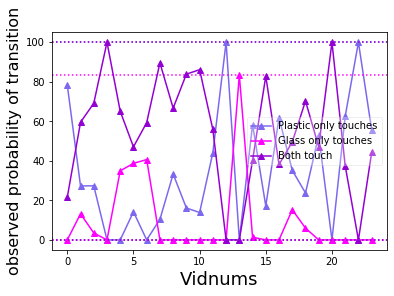

In [10]:

# Print probabilitie sby video
plotter(vidinds, vidsums.T, cols, 'Vidnums')


Now to get the observed probabilities, by stability threshold (the number of consecutive frames which must be registered as a state before the state changes; any break in the chain resets the counting). 

In [11]:
cprops = {}

# collect, for each video (in each run), the list of matrices recorded
for ind, expt in enumerate(stored_y_values.keys()):
    exptdicts = stored_y_values[expt]     
    for runnum, rundict in exptdicts.items():
        c_thresh = c_threshes[expt][runnum] #Where the selection magic happens
        keys = rundict.keys() # vifdeo number of run
        for key in keys: #evry video
            if c_thresh not in cprops.keys():
                cprops[c_thresh] = rundict[key]                
            else:
                cprops[c_thresh] = np.vstack((cprops[c_thresh], rundict[key]))
            #print("List of transition pairs for video {}: \n{}".format(key, vidprops[vidnumkey]))

#Got to double check!
keys = sorted(cprops.keys())
csums = [] #sum all the probabilities 
for key in keys:
    allprobs = cprops[key]
    print("Collected all probabilities for c_threshold  {}: \n{}".format(key, allprobs))
    if len(np.shape(allprobs)) > 1:
        allprobs_sum = np.sum(allprobs, axis = 0) / len(allprobs)
    else:
        allprobs_sum = allprobs
    csums.append(allprobs_sum )
    print("And summed and averaged all probabilities:\n{}\n".format(allprobs_sum))
csums = np.array(csums)
cinds = keys  
print("C_thresholds used:", cinds)
print("\nShape of total data array", np.shape(csums))




Collected all probabilities for c_threshold  20.0: 
[[  0.           0.         100.        ]
 [ 62.5          0.          37.5       ]
 [100.           0.           0.        ]
 [  0.         100.           0.        ]
 [ 30.95238095  16.66666667  52.38095238]
 [ 16.           0.          84.        ]
 [ 62.5          0.          37.5       ]
 [ 25.          25.          50.        ]
 [ 25.           0.          75.        ]
 [ 50.           0.          50.        ]
 [  0.           0.         100.        ]
 [ 66.66666667   0.          33.33333333]
 [100.           0.           0.        ]
 [ 40.           0.          60.        ]
 [  0.           0.         100.        ]
 [ 50.           0.          50.        ]
 [100.           0.           0.        ]
 [  0.         100.           0.        ]
 [ 39.28571429   0.          60.71428571]
 [ 13.04347826   0.          86.95652174]
 [ 57.14285714   0.          42.85714286]
 [ 20.          25.          55.        ]
 [ 25.           0.     

As you see, the proportions are not very sensitive to this. 

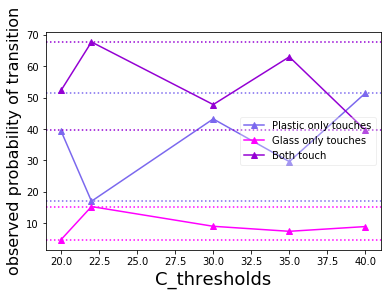

In [12]:
plotter(cinds, csums.T, cols, 'C_thresholds')

Now to get how the transition probabilities vary wrt the transition sthreshold (how many frames does a raft remain broken for before it is classified as broken. This only applies in the case of transitions to the same state as the original).

In [13]:
tprops = {}

# collect, for each video (in each run), the list of matrices recorded
for ind, expt in enumerate(stored_y_values.keys()):
    exptdicts = stored_y_values[expt]     
    for runnum, rundict in exptdicts.items():
        t_thresh = t_threshes[expt][runnum]
        keys = rundict.keys() # vifdeo number of run
        for key in keys: #evry video
            if t_thresh not in tprops.keys():
                tprops[t_thresh] = rundict[key]                
            else:
                tprops[t_thresh] = np.vstack((tprops[t_thresh], rundict[key]))
            #print("List of transition pairs for video {}: \n{}".format(key, vidprops[vidnumkey]))

#Got to double check!
keys = sorted(tprops.keys())
tsums = [] #sum all the probabilities 
for key in keys:
    allprobs = tprops[key]
    print("Collected all arrays for T_threshold  {}: \n{}".format(key, allprobs))
    if len(np.shape(allprobs)) > 1:
        allprobs_sum = np.sum(allprobs, axis = 0) / len(allprobs)
    else:
        allprobs_sum = allprobs
    tsums.append(allprobs_sum )
    print("And summed and averaged all probabilities:\n{}\n".format(allprobs_sum))
tsums = np.array(tsums)
tinds = keys  
print("T_thresholds used:", tinds)
print("\nShape of total data array", np.shape(tsums))



Collected all arrays for T_threshold  35.0: 
[[  0.           0.         100.        ]
 [ 62.5          0.          37.5       ]
 [100.           0.           0.        ]
 [  0.         100.           0.        ]
 [ 30.95238095  16.66666667  52.38095238]
 [ 16.           0.          84.        ]
 [ 62.5          0.          37.5       ]
 [ 25.          25.          50.        ]
 [ 25.           0.          75.        ]
 [ 50.           0.          50.        ]
 [  0.           0.         100.        ]
 [ 66.66666667   0.          33.33333333]
 [100.           0.           0.        ]
 [ 40.           0.          60.        ]
 [  0.           0.         100.        ]
 [ 57.14285714   0.          42.85714286]
 [100.           0.           0.        ]
 [  0.         100.           0.        ]
 [ 66.66666667   0.          33.33333333]
 [ 19.44444444   0.          80.55555556]
 [ 62.5          0.          37.5       ]
 [ 37.5         25.          37.5       ]
 [ 25.           8.33333333  66

Within the threshold range used, the probabilities are insensitive to this. 

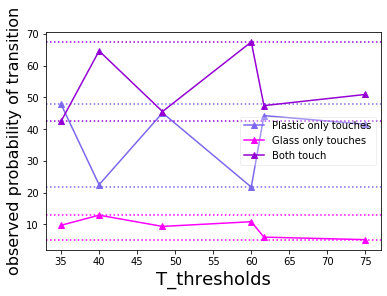

In [14]:
plotter(tinds, tsums.T, cols, 'T_thresholds')

One weakenss is an inability to recognize transitions that occur by unorthodox motions like sliding of one particle from the edge through the middle (which ahs been observed), if the final state isn't different than the original. 

Finally, for each pair of thresholds, the observed probailities of transition. 

In [15]:
rprops = {}
exptnum = 0
bignum = 100
# collect, for each video (in each run), the list of matrices recorded
for ind, expt in enumerate(stored_y_values.keys()):
    exptdicts = stored_y_values[expt]     
    for runnum, rundict in exptdicts.items(): 
        t_thresh = t_threshes[expt][runnum]
        c_thresh = c_threshes[expt][runnum]
        runkey = (t_thresh, c_thresh)
        keys = rundict.keys() # vifdeo number of run
        for key in keys: #evry video
            if runkey not in rprops.keys():
                rprops[runkey] = rundict[key]                
            else:
                rprops[runkey] = np.vstack((rprops[runkey], rundict[key]))
    exptnum += bignum

#Got to double check!
keys = sorted(rprops.keys())
rsums = [] #sum all the probabilities 
for key in keys:
    allprobs = rprops[key]
    print("Collected all arrays for run  {}: \n{}".format(key, allprobs))
    if len(np.shape(allprobs)) > 1:
        allprobs_sum = np.sum(allprobs, axis = 0) / len(allprobs)
    else:
        allprobs_sum = allprobs
    rsums.append(allprobs_sum )
    print("And summed and averaged all probabilities:\n{}\n".format(allprobs_sum))
rsums = np.array(rsums)
rinds = list(range(len(keys)))  
print("Runs done:",keys)
print("\nShape of total data array", np.shape(rsums))



Collected all arrays for run  (35.0, 20.0): 
[[  0.           0.         100.        ]
 [ 62.5          0.          37.5       ]
 [100.           0.           0.        ]
 [  0.         100.           0.        ]
 [ 30.95238095  16.66666667  52.38095238]
 [ 16.           0.          84.        ]
 [ 62.5          0.          37.5       ]
 [ 25.          25.          50.        ]
 [ 25.           0.          75.        ]
 [ 50.           0.          50.        ]
 [  0.           0.         100.        ]
 [ 66.66666667   0.          33.33333333]
 [100.           0.           0.        ]
 [ 40.           0.          60.        ]]
And summed and averaged all probabilities:
[41.32993197 10.11904762 48.55102041]

Collected all arrays for run  (35.0, 30.0): 
[[  0.           0.         100.        ]
 [ 57.14285714   0.          42.85714286]
 [100.           0.           0.        ]
 [  0.         100.           0.        ]
 [ 66.66666667   0.          33.33333333]
 [ 19.44444444   0.          

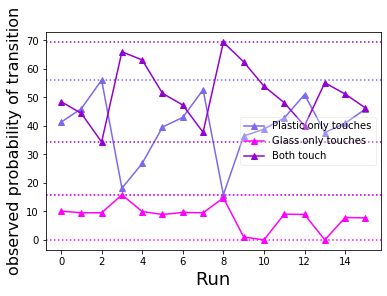

In [16]:
plotter(rinds, rsums.T, cols, 'Run') #max,min for each state

These matrices give what transition probabilities we expect if the particles were to move along th eperimeter of thr raft, in a 'hinging' motion. The moving particle is on the long axis (as they have fewer contacts),
and it uses a neighbouring particle on the short ais as its hinge. For each state, the particles on either end of the long 
axis are allowed to move either clockwise or counterclockwise, with no bias in either direction. Bonds broken in order to move are not included. 


In [17]:
alphas = np.linspace(0, 20, 100,endpoint =False)#glass
betas = np.linspace(0, 20, 100,endpoint =False)#plastic
x1 = []
x2 = []
x3 = []
for aln in range(len(alphas)):
    a = []
    b = []
    c = []
    i = alphas[aln]
    if i ==1:
        alpha1 = aln
    for bln in range(len(betas)):
        print('\nalpha= {}, beta = {}'.format(aln, bln))
        j = betas[bln]
        if j == 1:
            beta1 = bln
        
        T_expected_narrow =np.asarray([[0, 0, 2*(i+1)],
         [0, 0, 2*(j+1)],
                                       [2/(i+1), 2/(1+j), 2]])
        T_expected_broad = T_expected_narrow
        T_expected_broad_norm = np.vstack([T_expected_broad[i]/np.sum(T_expected_broad[i]) for i in range(len(T_expected_broad))])
        print('\n', np.around(T_expected_broad_norm, 2))
        eigvals, eigvecs = np.linalg.eig(T_expected_broad_norm.T)
        eig_one_index = [x for x in range(len(eigvals)) if math.isclose(eigvals[x], 1.0, abs_tol = .0001)][0]
        eigvec_one = eigvecs[:, eig_one_index]
        evec_one = eigvec_one*100 / np.sum(eigvec_one)
        a.append(evec_one[0])
        b.append(evec_one[1])
        c.append(evec_one[2])
    x1.append(a)
    x2.append(b)
    x3.append(c)


alpha= 0, beta = 0

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.33 0.33 0.33]]

alpha= 0, beta = 1

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.35 0.29 0.35]]

alpha= 0, beta = 2

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.37 0.26 0.37]]

alpha= 0, beta = 3

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.38 0.24 0.38]]

alpha= 0, beta = 4

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.39 0.22 0.39]]

alpha= 0, beta = 5

 [[0.  0.  1. ]
 [0.  0.  1. ]
 [0.4 0.2 0.4]]

alpha= 0, beta = 6

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.41 0.19 0.41]]

alpha= 0, beta = 7

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.41 0.17 0.41]]

alpha= 0, beta = 8

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.42 0.16 0.42]]

alpha= 0, beta = 9

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.42 0.15 0.42]]

alpha= 0, beta = 10

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.43 0.14 0.43]]

alpha= 0, beta = 11

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.43 0.14 0.43]]

alpha= 0, beta = 12

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.44 0.13 0.44]]

alph

 [0.4  0.04 0.56]]

alpha= 2, beta = 60

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.4  0.04 0.56]]

alpha= 2, beta = 61

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.4  0.04 0.56]]

alpha= 2, beta = 62

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.4  0.04 0.56]]

alpha= 2, beta = 63

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.4  0.04 0.56]]

alpha= 2, beta = 64

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.4  0.04 0.56]]

alpha= 2, beta = 65

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.4  0.04 0.56]]

alpha= 2, beta = 66

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.4  0.04 0.56]]

alpha= 2, beta = 67

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.4  0.04 0.56]]

alpha= 2, beta = 68

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.4  0.04 0.56]]

alpha= 2, beta = 69

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.4  0.04 0.56]]

alpha= 2, beta = 70

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.4  0.04 0.56]]

alpha= 2, beta = 71

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.4  0.04 0.56]]

alpha= 2, beta = 72

 [[0.   0.   1.  ]
 [0.

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.29 0.13 0.58]]

alpha= 5, beta = 19

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.29 0.12 0.59]]

alpha= 5, beta = 20

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.29 0.12 0.59]]

alpha= 5, beta = 21

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.3  0.11 0.59]]

alpha= 5, beta = 22

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.3  0.11 0.59]]

alpha= 5, beta = 23

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.3  0.11 0.6 ]]

alpha= 5, beta = 24

 [[0.  0.  1. ]
 [0.  0.  1. ]
 [0.3 0.1 0.6]]

alpha= 5, beta = 25

 [[0.  0.  1. ]
 [0.  0.  1. ]
 [0.3 0.1 0.6]]

alpha= 5, beta = 26

 [[0.  0.  1. ]
 [0.  0.  1. ]
 [0.3 0.1 0.6]]

alpha= 5, beta = 27

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.3  0.09 0.6 ]]

alpha= 5, beta = 28

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.3  0.09 0.61]]

alpha= 5, beta = 29

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.3  0.09 0.61]]

alpha= 5, beta = 30

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.3  0.09 0.61]]

alpha= 5, beta = 31

 [[0.   0.   

 [0.28 0.05 0.67]]

alpha= 7, beta = 68

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.28 0.05 0.67]]

alpha= 7, beta = 69

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.28 0.05 0.67]]

alpha= 7, beta = 70

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.28 0.04 0.67]]

alpha= 7, beta = 71

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.28 0.04 0.67]]

alpha= 7, beta = 72

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.28 0.04 0.67]]

alpha= 7, beta = 73

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.28 0.04 0.68]]

alpha= 7, beta = 74

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.28 0.04 0.68]]

alpha= 7, beta = 75

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.28 0.04 0.68]]

alpha= 7, beta = 76

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.28 0.04 0.68]]

alpha= 7, beta = 77

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.28 0.04 0.68]]

alpha= 7, beta = 78

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.28 0.04 0.68]]

alpha= 7, beta = 79

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.28 0.04 0.68]]

alpha= 7, beta = 80

 [[0.   0.   1.  ]
 [0.

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.23 0.08 0.69]]

alpha= 10, beta = 37

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.23 0.08 0.69]]

alpha= 10, beta = 38

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.23 0.08 0.69]]

alpha= 10, beta = 39

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.23 0.08 0.69]]

alpha= 10, beta = 40

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.23 0.08 0.69]]

alpha= 10, beta = 41

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.23 0.08 0.69]]

alpha= 10, beta = 42

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.23 0.07 0.69]]

alpha= 10, beta = 43

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.23 0.07 0.7 ]]

alpha= 10, beta = 44

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.23 0.07 0.7 ]]

alpha= 10, beta = 45

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.23 0.07 0.7 ]]

alpha= 10, beta = 46

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.23 0.07 0.7 ]]

alpha= 10, beta = 47

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.23 0.07 0.7 ]]

alpha= 10, beta = 48

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.23 0.07 0.7


 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.19 0.11 0.7 ]]

alpha= 13, beta = 28

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.19 0.11 0.7 ]]

alpha= 13, beta = 29

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.19 0.1  0.7 ]]

alpha= 13, beta = 30

 [[0.  0.  1. ]
 [0.  0.  1. ]
 [0.2 0.1 0.7]]

alpha= 13, beta = 31

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.2  0.1  0.71]]

alpha= 13, beta = 32

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.2  0.1  0.71]]

alpha= 13, beta = 33

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.2  0.09 0.71]]

alpha= 13, beta = 34

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.2  0.09 0.71]]

alpha= 13, beta = 35

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.2  0.09 0.71]]

alpha= 13, beta = 36

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.2  0.09 0.71]]

alpha= 13, beta = 37

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.2  0.09 0.72]]

alpha= 13, beta = 38

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.2  0.08 0.72]]

alpha= 13, beta = 39

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.2  0.08 0.72]]

alp

alpha= 15, beta = 79

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.19 0.05 0.76]]

alpha= 15, beta = 80

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.19 0.04 0.76]]

alpha= 15, beta = 81

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.19 0.04 0.76]]

alpha= 15, beta = 82

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.19 0.04 0.76]]

alpha= 15, beta = 83

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.19 0.04 0.77]]

alpha= 15, beta = 84

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.19 0.04 0.77]]

alpha= 15, beta = 85

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.19 0.04 0.77]]

alpha= 15, beta = 86

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.19 0.04 0.77]]

alpha= 15, beta = 87

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.19 0.04 0.77]]

alpha= 15, beta = 88

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.19 0.04 0.77]]

alpha= 15, beta = 89

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.19 0.04 0.77]]

alpha= 15, beta = 90

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.19 0.04 0.77]]

alpha= 15, beta = 91

 [[0.   0.   1.  ]
 [0.   0.  

 [0.17 0.06 0.77]]

alpha= 18, beta = 61

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.17 0.06 0.77]]

alpha= 18, beta = 62

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.17 0.06 0.77]]

alpha= 18, beta = 63

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.17 0.06 0.77]]

alpha= 18, beta = 64

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.17 0.06 0.78]]

alpha= 18, beta = 65

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.17 0.06 0.78]]

alpha= 18, beta = 66

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.17 0.05 0.78]]

alpha= 18, beta = 67

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.17 0.05 0.78]]

alpha= 18, beta = 68

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.17 0.05 0.78]]

alpha= 18, beta = 69

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.17 0.05 0.78]]

alpha= 18, beta = 70

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.17 0.05 0.78]]

alpha= 18, beta = 71

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.17 0.05 0.78]]

alpha= 18, beta = 72

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.17 0.05 0.78]]

alpha= 18, beta = 73

 [[0.   0.

alpha= 21, beta = 0

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.09 0.46 0.46]]

alpha= 21, beta = 1

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.09 0.41 0.49]]

alpha= 21, beta = 2

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.37 0.52]]

alpha= 21, beta = 3

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.11 0.34 0.55]]

alpha= 21, beta = 4

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.11 0.32 0.57]]

alpha= 21, beta = 5

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.11 0.3  0.59]]

alpha= 21, beta = 6

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.12 0.28 0.61]]

alpha= 21, beta = 7

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.12 0.26 0.62]]

alpha= 21, beta = 8

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.12 0.24 0.63]]

alpha= 21, beta = 9

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.12 0.23 0.65]]

alpha= 21, beta = 10

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.13 0.22 0.66]]

alpha= 21, beta = 11

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.13 0.21 0.66]]

alpha= 21, beta = 12

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0

 [0.14 0.06 0.8 ]]

alpha= 23, beta = 62

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.14 0.06 0.8 ]]

alpha= 23, beta = 63

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.14 0.06 0.8 ]]

alpha= 23, beta = 64

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.14 0.06 0.8 ]]

alpha= 23, beta = 65

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.14 0.06 0.8 ]]

alpha= 23, beta = 66

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.14 0.06 0.8 ]]

alpha= 23, beta = 67

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.14 0.06 0.8 ]]

alpha= 23, beta = 68

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.14 0.05 0.8 ]]

alpha= 23, beta = 69

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.14 0.05 0.8 ]]

alpha= 23, beta = 70

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.14 0.05 0.8 ]]

alpha= 23, beta = 71

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.14 0.05 0.8 ]]

alpha= 23, beta = 72

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.14 0.05 0.8 ]]

alpha= 23, beta = 73

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.14 0.05 0.8 ]]

alpha= 23, beta = 74

 [[0.   0.

 [0.12 0.13 0.75]]

alpha= 26, beta = 25

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.12 0.13 0.75]]

alpha= 26, beta = 26

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.12 0.12 0.76]]

alpha= 26, beta = 27

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.12 0.12 0.76]]

alpha= 26, beta = 28

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.12 0.12 0.76]]

alpha= 26, beta = 29

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.12 0.11 0.76]]

alpha= 26, beta = 30

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.12 0.11 0.77]]

alpha= 26, beta = 31

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.12 0.11 0.77]]

alpha= 26, beta = 32

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.12 0.1  0.77]]

alpha= 26, beta = 33

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.12 0.1  0.77]]

alpha= 26, beta = 34

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.13 0.1  0.78]]

alpha= 26, beta = 35

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.13 0.1  0.78]]

alpha= 26, beta = 36

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.13 0.1  0.78]]

alpha= 26, beta = 37

 [[0.   0.

 [0.11 0.13 0.76]]

alpha= 29, beta = 25

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.11 0.13 0.76]]

alpha= 29, beta = 26

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.11 0.12 0.76]]

alpha= 29, beta = 27

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.11 0.12 0.77]]

alpha= 29, beta = 28

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.11 0.12 0.77]]

alpha= 29, beta = 29

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.11 0.11 0.77]]

alpha= 29, beta = 30

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.11 0.11 0.78]]

alpha= 29, beta = 31

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.11 0.11 0.78]]

alpha= 29, beta = 32

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.11 0.11 0.78]]

alpha= 29, beta = 33

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.12 0.1  0.78]]

alpha= 29, beta = 34

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.12 0.1  0.78]]

alpha= 29, beta = 35

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.12 0.1  0.79]]

alpha= 29, beta = 36

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.12 0.1  0.79]]

alpha= 29, beta = 37

 [[0.   0.

alpha= 31, beta = 87

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.12 0.05 0.84]]

alpha= 31, beta = 88

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.12 0.05 0.84]]

alpha= 31, beta = 89

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.12 0.04 0.84]]

alpha= 31, beta = 90

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.12 0.04 0.84]]

alpha= 31, beta = 91

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.12 0.04 0.84]]

alpha= 31, beta = 92

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.12 0.04 0.84]]

alpha= 31, beta = 93

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.12 0.04 0.84]]

alpha= 31, beta = 94

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.12 0.04 0.84]]

alpha= 31, beta = 95

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.12 0.04 0.84]]

alpha= 31, beta = 96

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.12 0.04 0.84]]

alpha= 31, beta = 97

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.12 0.04 0.84]]

alpha= 31, beta = 98

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.12 0.04 0.84]]

alpha= 31, beta = 99

 [[0.   0.   1.  ]
 [0.   0.  

 [0.1 0.1 0.8]]

alpha= 34, beta = 36

 [[0.  0.  1. ]
 [0.  0.  1. ]
 [0.1 0.1 0.8]]

alpha= 34, beta = 37

 [[0.  0.  1. ]
 [0.  0.  1. ]
 [0.1 0.1 0.8]]

alpha= 34, beta = 38

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.09 0.8 ]]

alpha= 34, beta = 39

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.09 0.81]]

alpha= 34, beta = 40

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.09 0.81]]

alpha= 34, beta = 41

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.09 0.81]]

alpha= 34, beta = 42

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.09 0.81]]

alpha= 34, beta = 43

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.08 0.81]]

alpha= 34, beta = 44

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.08 0.81]]

alpha= 34, beta = 45

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.08 0.81]]

alpha= 34, beta = 46

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.08 0.82]]

alpha= 34, beta = 47

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.08 0.82]]

alpha= 34, beta = 48

 [[0.   0.   1.  ]
 [0.   0.   

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.04 0.85]]

alpha= 36, beta = 92

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.04 0.85]]

alpha= 36, beta = 93

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.04 0.85]]

alpha= 36, beta = 94

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.04 0.85]]

alpha= 36, beta = 95

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.04 0.85]]

alpha= 36, beta = 96

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.04 0.85]]

alpha= 36, beta = 97

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.04 0.85]]

alpha= 36, beta = 98

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.04 0.85]]

alpha= 36, beta = 99

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.04 0.85]]

alpha= 37, beta = 0

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.47 0.47]]

alpha= 37, beta = 1

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.43 0.51]]

alpha= 37, beta = 2

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.39 0.55]]

alpha= 37, beta = 3

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.36 0.57]]


 [0.1  0.05 0.85]]

alpha= 39, beta = 82

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.05 0.85]]

alpha= 39, beta = 83

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.05 0.85]]

alpha= 39, beta = 84

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.05 0.85]]

alpha= 39, beta = 85

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.05 0.86]]

alpha= 39, beta = 86

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.05 0.86]]

alpha= 39, beta = 87

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.05 0.86]]

alpha= 39, beta = 88

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.05 0.86]]

alpha= 39, beta = 89

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.05 0.86]]

alpha= 39, beta = 90

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.05 0.86]]

alpha= 39, beta = 91

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.04 0.86]]

alpha= 39, beta = 92

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.04 0.86]]

alpha= 39, beta = 93

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.1  0.04 0.86]]

alpha= 39, beta = 94

 [[0.   0.

 [0.09 0.07 0.84]]

alpha= 42, beta = 57

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.09 0.07 0.84]]

alpha= 42, beta = 58

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.09 0.07 0.84]]

alpha= 42, beta = 59

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.09 0.07 0.84]]

alpha= 42, beta = 60

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.09 0.07 0.85]]

alpha= 42, beta = 61

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.09 0.06 0.85]]

alpha= 42, beta = 62

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.09 0.06 0.85]]

alpha= 42, beta = 63

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.09 0.06 0.85]]

alpha= 42, beta = 64

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.09 0.06 0.85]]

alpha= 42, beta = 65

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.09 0.06 0.85]]

alpha= 42, beta = 66

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.09 0.06 0.85]]

alpha= 42, beta = 67

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.09 0.06 0.85]]

alpha= 42, beta = 68

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.09 0.06 0.85]]

alpha= 42, beta = 69

 [[0.   0.

 [0.08 0.16 0.76]]

alpha= 45, beta = 20

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.15 0.77]]

alpha= 45, beta = 21

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.15 0.77]]

alpha= 45, beta = 22

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.14 0.78]]

alpha= 45, beta = 23

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.14 0.78]]

alpha= 45, beta = 24

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.14 0.79]]

alpha= 45, beta = 25

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.13 0.79]]

alpha= 45, beta = 26

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.13 0.79]]

alpha= 45, beta = 27

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.12 0.8 ]]

alpha= 45, beta = 28

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.12 0.8 ]]

alpha= 45, beta = 29

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.12 0.8 ]]

alpha= 45, beta = 30

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.11 0.8 ]]

alpha= 45, beta = 31

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.11 0.81]]

alpha= 45, beta = 32

 [[0.   0.

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.05 0.87]]

alpha= 47, beta = 81

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.05 0.87]]

alpha= 47, beta = 82

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.05 0.87]]

alpha= 47, beta = 83

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.05 0.87]]

alpha= 47, beta = 84

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.05 0.87]]

alpha= 47, beta = 85

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.05 0.87]]

alpha= 47, beta = 86

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.05 0.87]]

alpha= 47, beta = 87

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.05 0.87]]

alpha= 47, beta = 88

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.05 0.87]]

alpha= 47, beta = 89

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.05 0.87]]

alpha= 47, beta = 90

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.05 0.87]]

alpha= 47, beta = 91

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.05 0.87]]

alpha= 47, beta = 92

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.04 0.8

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.07 0.85]]

alpha= 50, beta = 54

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.07 0.85]]

alpha= 50, beta = 55

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.07 0.85]]

alpha= 50, beta = 56

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.07 0.85]]

alpha= 50, beta = 57

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.07 0.85]]

alpha= 50, beta = 58

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.07 0.85]]

alpha= 50, beta = 59

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.07 0.86]]

alpha= 50, beta = 60

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.07 0.86]]

alpha= 50, beta = 61

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.06 0.86]]

alpha= 50, beta = 62

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.06 0.86]]

alpha= 50, beta = 63

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.06 0.86]]

alpha= 50, beta = 64

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.06 0.86]]

alpha= 50, beta = 65

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.08 0.06 0.8


alpha= 53, beta = 15

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.19 0.75]]

alpha= 53, beta = 16

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.18 0.76]]

alpha= 53, beta = 17

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.17 0.76]]

alpha= 53, beta = 18

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.17 0.77]]

alpha= 53, beta = 19

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.16 0.77]]

alpha= 53, beta = 20

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.16 0.78]]

alpha= 53, beta = 21

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.15 0.78]]

alpha= 53, beta = 22

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.15 0.79]]

alpha= 53, beta = 23

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.14 0.79]]

alpha= 53, beta = 24

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.14 0.79]]

alpha= 53, beta = 25

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.13 0.8 ]]

alpha= 53, beta = 26

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.13 0.8 ]]

alpha= 53, beta = 27

 [[0.   0.   1.  ]
 [0.   0. 

 [0.07 0.04 0.88]]

alpha= 55, beta = 99

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.04 0.88]]

alpha= 56, beta = 0

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.48 0.48]]

alpha= 56, beta = 1

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.44 0.52]]

alpha= 56, beta = 2

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.4  0.56]]

alpha= 56, beta = 3

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.37 0.59]]

alpha= 56, beta = 4

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.34 0.61]]

alpha= 56, beta = 5

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.32 0.63]]

alpha= 56, beta = 6

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.3  0.65]]

alpha= 56, beta = 7

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.28 0.67]]

alpha= 56, beta = 8

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.26 0.68]]

alpha= 56, beta = 9

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.25 0.69]]

alpha= 56, beta = 10

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.24 0.71]]

alpha= 56, beta = 11

 [[0.   0.   1.  ]
 

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.05 0.88]]

alpha= 58, beta = 79

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.05 0.88]]

alpha= 58, beta = 80

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.05 0.88]]

alpha= 58, beta = 81

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.05 0.88]]

alpha= 58, beta = 82

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.05 0.88]]

alpha= 58, beta = 83

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.05 0.88]]

alpha= 58, beta = 84

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.05 0.88]]

alpha= 58, beta = 85

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.05 0.88]]

alpha= 58, beta = 86

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.05 0.88]]

alpha= 58, beta = 87

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.05 0.88]]

alpha= 58, beta = 88

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.05 0.88]]

alpha= 58, beta = 89

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.05 0.88]]

alpha= 58, beta = 90

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.05 0.8

 [0.07 0.07 0.86]]

alpha= 61, beta = 56

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.07 0.86]]

alpha= 61, beta = 57

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.07 0.86]]

alpha= 61, beta = 58

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.07 0.87]]

alpha= 61, beta = 59

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.07 0.87]]

alpha= 61, beta = 60

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.07 0.87]]

alpha= 61, beta = 61

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.07 0.87]]

alpha= 61, beta = 62

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.06 0.87]]

alpha= 61, beta = 63

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.06 0.87]]

alpha= 61, beta = 64

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.06 0.87]]

alpha= 61, beta = 65

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.06 0.87]]

alpha= 61, beta = 66

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.06 0.87]]

alpha= 61, beta = 67

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.07 0.06 0.87]]

alpha= 61, beta = 68

 [[0.   0.

 [0.06 0.09 0.85]]

alpha= 64, beta = 44

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.09 0.85]]

alpha= 64, beta = 45

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.09 0.85]]

alpha= 64, beta = 46

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.08 0.85]]

alpha= 64, beta = 47

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.08 0.86]]

alpha= 64, beta = 48

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.08 0.86]]

alpha= 64, beta = 49

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.08 0.86]]

alpha= 64, beta = 50

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.08 0.86]]

alpha= 64, beta = 51

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.08 0.86]]

alpha= 64, beta = 52

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.08 0.86]]

alpha= 64, beta = 53

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.07 0.86]]

alpha= 64, beta = 54

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.07 0.86]]

alpha= 64, beta = 55

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.07 0.87]]

alpha= 64, beta = 56

 [[0.   0.

 [0.05 0.21 0.74]]

alpha= 67, beta = 14

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.2  0.75]]

alpha= 67, beta = 15

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.19 0.76]]

alpha= 67, beta = 16

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.18 0.76]]

alpha= 67, beta = 17

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.18 0.77]]

alpha= 67, beta = 18

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.17 0.78]]

alpha= 67, beta = 19

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.16 0.78]]

alpha= 67, beta = 20

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.16 0.79]]

alpha= 67, beta = 21

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.15 0.79]]

alpha= 67, beta = 22

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.15 0.8 ]]

alpha= 67, beta = 23

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.14 0.8 ]]

alpha= 67, beta = 24

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.14 0.81]]

alpha= 67, beta = 25

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.13 0.81]]

alpha= 67, beta = 26

 [[0.   0.

alpha= 69, beta = 67

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.06 0.88]]

alpha= 69, beta = 68

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.06 0.88]]

alpha= 69, beta = 69

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.06 0.88]]

alpha= 69, beta = 70

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.06 0.88]]

alpha= 69, beta = 71

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.06 0.88]]

alpha= 69, beta = 72

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.06 0.88]]

alpha= 69, beta = 73

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.06 0.88]]

alpha= 69, beta = 74

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.06 0.88]]

alpha= 69, beta = 75

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.06 0.88]]

alpha= 69, beta = 76

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.05 0.89]]

alpha= 69, beta = 77

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.05 0.89]]

alpha= 69, beta = 78

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.05 0.89]]

alpha= 69, beta = 79

 [[0.   0.   1.  ]
 [0.   0.  


 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.06 0.89]]

alpha= 72, beta = 75

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.06 0.89]]

alpha= 72, beta = 76

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.05 0.89]]

alpha= 72, beta = 77

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.05 0.89]]

alpha= 72, beta = 78

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.05 0.89]]

alpha= 72, beta = 79

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.05 0.89]]

alpha= 72, beta = 80

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.05 0.89]]

alpha= 72, beta = 81

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.05 0.89]]

alpha= 72, beta = 82

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.05 0.89]]

alpha= 72, beta = 83

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.05 0.89]]

alpha= 72, beta = 84

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.05 0.89]]

alpha= 72, beta = 85

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.05 0.89]]

alpha= 72, beta = 86

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.05 0.

alpha= 74, beta = 72

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.06 0.89]]

alpha= 74, beta = 73

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.06 0.89]]

alpha= 74, beta = 74

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.06 0.89]]

alpha= 74, beta = 75

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.06 0.89]]

alpha= 74, beta = 76

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.05 0.89]]

alpha= 74, beta = 77

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.05 0.89]]

alpha= 74, beta = 78

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.05 0.89]]

alpha= 74, beta = 79

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.05 0.89]]

alpha= 74, beta = 80

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.05 0.89]]

alpha= 74, beta = 81

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.05 0.89]]

alpha= 74, beta = 82

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.05 0.89]]

alpha= 74, beta = 83

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.06 0.05 0.89]]

alpha= 74, beta = 84

 [[0.   0.   1.  ]
 [0.   0.  


alpha= 77, beta = 43

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.09 0.86]]

alpha= 77, beta = 44

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.09 0.86]]

alpha= 77, beta = 45

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.09 0.86]]

alpha= 77, beta = 46

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.08 0.86]]

alpha= 77, beta = 47

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.08 0.86]]

alpha= 77, beta = 48

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.08 0.87]]

alpha= 77, beta = 49

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.08 0.87]]

alpha= 77, beta = 50

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.08 0.87]]

alpha= 77, beta = 51

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.08 0.87]]

alpha= 77, beta = 52

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.08 0.87]]

alpha= 77, beta = 53

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.08 0.87]]

alpha= 77, beta = 54

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.07 0.87]]

alpha= 77, beta = 55

 [[0.   0.   1.  ]
 [0.   0. 

 [0.05 0.15 0.8 ]]

alpha= 80, beta = 22

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.15 0.8 ]]

alpha= 80, beta = 23

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.14 0.81]]

alpha= 80, beta = 24

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.14 0.81]]

alpha= 80, beta = 25

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.14 0.82]]

alpha= 80, beta = 26

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.13 0.82]]

alpha= 80, beta = 27

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.13 0.82]]

alpha= 80, beta = 28

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.13 0.83]]

alpha= 80, beta = 29

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.12 0.83]]

alpha= 80, beta = 30

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.12 0.83]]

alpha= 80, beta = 31

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.12 0.83]]

alpha= 80, beta = 32

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.11 0.84]]

alpha= 80, beta = 33

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.11 0.84]]

alpha= 80, beta = 34

 [[0.   0.

alpha= 82, beta = 79

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.05 0.9 ]]

alpha= 82, beta = 80

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.05 0.9 ]]

alpha= 82, beta = 81

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.05 0.9 ]]

alpha= 82, beta = 82

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.05 0.9 ]]

alpha= 82, beta = 83

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.05 0.9 ]]

alpha= 82, beta = 84

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.05 0.9 ]]

alpha= 82, beta = 85

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.05 0.9 ]]

alpha= 82, beta = 86

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.05 0.9 ]]

alpha= 82, beta = 87

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.05 0.9 ]]

alpha= 82, beta = 88

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.05 0.9 ]]

alpha= 82, beta = 89

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.05 0.9 ]]

alpha= 82, beta = 90

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.05 0.9 ]]

alpha= 82, beta = 91

 [[0.   0.   1.  ]
 [0.   0.  

 [0.05 0.12 0.83]]

alpha= 85, beta = 31

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.12 0.84]]

alpha= 85, beta = 32

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.11 0.84]]

alpha= 85, beta = 33

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.11 0.84]]

alpha= 85, beta = 34

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.11 0.84]]

alpha= 85, beta = 35

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.11 0.85]]

alpha= 85, beta = 36

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.1  0.85]]

alpha= 85, beta = 37

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.1  0.85]]

alpha= 85, beta = 38

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.1  0.85]]

alpha= 85, beta = 39

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.1  0.86]]

alpha= 85, beta = 40

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.1  0.86]]

alpha= 85, beta = 41

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.09 0.86]]

alpha= 85, beta = 42

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.09 0.86]]

alpha= 85, beta = 43

 [[0.   0.

 [0.05 0.05 0.9 ]]

alpha= 87, beta = 90

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.05 0.9 ]]

alpha= 87, beta = 91

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.05 0.9 ]]

alpha= 87, beta = 92

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.05 0.9 ]]

alpha= 87, beta = 93

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.05 0.9 ]]

alpha= 87, beta = 94

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.05 0.91]]

alpha= 87, beta = 95

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.05 0.91]]

alpha= 87, beta = 96

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.04 0.91]]

alpha= 87, beta = 97

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.04 0.91]]

alpha= 87, beta = 98

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.04 0.91]]

alpha= 87, beta = 99

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.04 0.91]]

alpha= 88, beta = 0

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.03 0.49 0.49]]

alpha= 88, beta = 1

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.03 0.44 0.53]]

alpha= 88, beta = 2

 [[0.   0.   

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.13 0.83]]

alpha= 90, beta = 28

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.13 0.83]]

alpha= 90, beta = 29

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.12 0.83]]

alpha= 90, beta = 30

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.12 0.84]]

alpha= 90, beta = 31

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.12 0.84]]

alpha= 90, beta = 32

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.11 0.84]]

alpha= 90, beta = 33

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.11 0.84]]

alpha= 90, beta = 34

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.11 0.85]]

alpha= 90, beta = 35

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.11 0.85]]

alpha= 90, beta = 36

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.1  0.85]]

alpha= 90, beta = 37

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.1  0.85]]

alpha= 90, beta = 38

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.1  0.86]]

alpha= 90, beta = 39

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.1  0.8

 [0.04 0.18 0.78]]

alpha= 93, beta = 17

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.18 0.78]]

alpha= 93, beta = 18

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.17 0.79]]

alpha= 93, beta = 19

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.17 0.79]]

alpha= 93, beta = 20

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.16 0.8 ]]

alpha= 93, beta = 21

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.15 0.8 ]]

alpha= 93, beta = 22

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.15 0.81]]

alpha= 93, beta = 23

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.15 0.81]]

alpha= 93, beta = 24

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.14 0.82]]

alpha= 93, beta = 25

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.14 0.82]]

alpha= 93, beta = 26

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.13 0.82]]

alpha= 93, beta = 27

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.13 0.83]]

alpha= 93, beta = 28

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.13 0.83]]

alpha= 93, beta = 29

 [[0.   0.

 [0.05 0.05 0.9 ]]

alpha= 95, beta = 83

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.05 0.9 ]]

alpha= 95, beta = 84

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.05 0.9 ]]

alpha= 95, beta = 85

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.05 0.9 ]]

alpha= 95, beta = 86

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.05 0.91]]

alpha= 95, beta = 87

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.05 0.91]]

alpha= 95, beta = 88

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.05 0.91]]

alpha= 95, beta = 89

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.05 0.91]]

alpha= 95, beta = 90

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.05 0.91]]

alpha= 95, beta = 91

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.05 0.91]]

alpha= 95, beta = 92

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.05 0.91]]

alpha= 95, beta = 93

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.05 0.91]]

alpha= 95, beta = 94

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.05 0.05 0.91]]

alpha= 95, beta = 95

 [[0.   0.

 [0.04 0.11 0.85]]

alpha= 98, beta = 34

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.11 0.85]]

alpha= 98, beta = 35

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.11 0.85]]

alpha= 98, beta = 36

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.1  0.85]]

alpha= 98, beta = 37

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.1  0.86]]

alpha= 98, beta = 38

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.1  0.86]]

alpha= 98, beta = 39

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.1  0.86]]

alpha= 98, beta = 40

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.1  0.86]]

alpha= 98, beta = 41

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.09 0.86]]

alpha= 98, beta = 42

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.09 0.87]]

alpha= 98, beta = 43

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.09 0.87]]

alpha= 98, beta = 44

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.09 0.87]]

alpha= 98, beta = 45

 [[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.04 0.09 0.87]]

alpha= 98, beta = 46

 [[0.   0.

The bold lines show the expected probailities of transitioning to each state, with a given ratio of bond strength, where alpha represents the ratio of a styrene-ethylene bond over a styrene-styrene bond. The inverse of this is called the (relative) styrene bond strength. 
This probability the same as the proportion of transitions from the state, at steady state.

The dashed lines represent the observed probabilities of transitions. As there is no interesection between the dashed and bold lines, this model does not capture the data. 

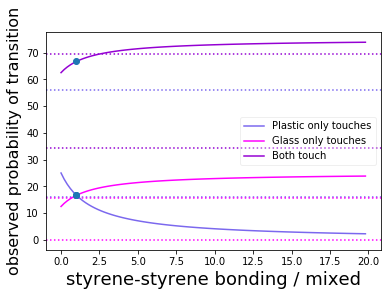

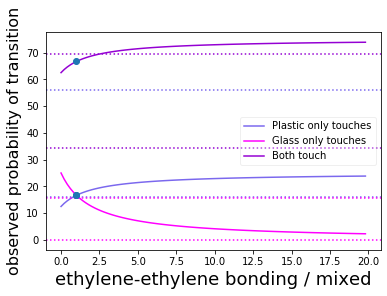

In [18]:

lines =[x1, x2,x3]
#print(lines, np.shape(lines))
eig_plotter(alphas, [[row[beta1] for row in x] for x in lines], cols, 'styrene-styrene bonding / mixed', rsums.T) #using rsum = runs for ranges
eig_plotter(betas, [y[alpha1] for y in lines], cols, 'ethylene-ethylene bonding / mixed', rsums.T) #using rsum = runs for ranges

This is the same as before, but the bond formed (weighted by their strenghts) are divided by the bonds broken, which provides as cost to motion. 
In the 3-polystyren case, this does capture the data, indicated by both pairs of coloured lines crossing at about the same alpha value. 

This means tha the transition statistics we see are possible using only hinge mtion (although both types of motion do inf act occur). 

In other cases, such as some 3-polyethylene runs, it is not possible to reocver the statistics using only hinge mption. 



Breaking apart !!

In [19]:
alphas = np.linspace(0, 20, 100,endpoint =False)#glass
betas = np.linspace(0, 20, 100,endpoint =False)#plastic
x1 = []
x2 = []
x3 = []
for aln in range(len(alphas)):
    a = []
    b = []
    c = []
    i = alphas[aln]
    if i ==1:
        alpha1 = aln
    for bln in range(len(betas)):
        print('\nalpha= {}, beta = {}'.format(aln, bln))
        j = betas[bln]
        if j == 1:
            beta1 = bln
        
        p = (j*2/(18*(1+i+j)*(3+i))+
             4*2*(j+1)/(18*2*(3+i)*(1+i+j)*(2+i+j)))
        g = (i*2/(18*(1+i+j)*(3+j))+
             4*2*(i+1)/(18*2*(3+j)*(1+i+j)*(2+i+j)))
        m = (2*j*(i+1)/(18*(3+i)*(1+j+i))+
              8*(i+1)*(j+1)/(18*2*(3+j)*(i+j+1)*(i+j+2))+
              8*(j+1)*(i+1)/(18*2*(3+i)*(i+j+1)*(i+j+2))+
              i*2*(1+j)/(18*(3+j)*(1+i+j)))

        T_expected_narrow = np.asarray([[p, g, m],
                                        [p, g, m],
         [p, g, m]])
        T_expected_broad = T_expected_narrow
        T_expected_broad_norm = np.vstack([T_expected_broad[i]/np.sum(T_expected_broad[i]) for i in range(len(T_expected_broad))])
        print('\n', np.around(T_expected_broad_norm, 2))
        eigvals, eigvecs = np.linalg.eig(T_expected_broad_norm.T)
        eig_one_index = [x for x in range(len(eigvals)) if math.isclose(eigvals[x], 1.0, abs_tol = .0001)][0]
        eigvec_one = eigvecs[:, eig_one_index]
        evec_one = eigvec_one*100 / np.sum(eigvec_one)
        a.append(evec_one[0])
        b.append(evec_one[1])
        c.append(evec_one[2])
    x1.append(a)
    x2.append(b)
    x3.append(c)
    
    


alpha= 0, beta = 0

 [[0.25 0.25 0.5 ]
 [0.25 0.25 0.5 ]
 [0.25 0.25 0.5 ]]

alpha= 0, beta = 1

 [[0.29 0.19 0.52]
 [0.29 0.19 0.52]
 [0.29 0.19 0.52]]

alpha= 0, beta = 2

 [[0.32 0.15 0.53]
 [0.32 0.15 0.53]
 [0.32 0.15 0.53]]

alpha= 0, beta = 3

 [[0.34 0.12 0.54]
 [0.34 0.12 0.54]
 [0.34 0.12 0.54]]

alpha= 0, beta = 4

 [[0.36 0.1  0.54]
 [0.36 0.1  0.54]
 [0.36 0.1  0.54]]

alpha= 0, beta = 5

 [[0.38 0.08 0.54]
 [0.38 0.08 0.54]
 [0.38 0.08 0.54]]

alpha= 0, beta = 6

 [[0.39 0.07 0.54]
 [0.39 0.07 0.54]
 [0.39 0.07 0.54]]

alpha= 0, beta = 7

 [[0.4  0.06 0.54]
 [0.4  0.06 0.54]
 [0.4  0.06 0.54]]

alpha= 0, beta = 8

 [[0.41 0.05 0.54]
 [0.41 0.05 0.54]
 [0.41 0.05 0.54]]

alpha= 0, beta = 9

 [[0.42 0.04 0.54]
 [0.42 0.04 0.54]
 [0.42 0.04 0.54]]

alpha= 0, beta = 10

 [[0.43 0.04 0.54]
 [0.43 0.04 0.54]
 [0.43 0.04 0.54]]

alpha= 0, beta = 11

 [[0.43 0.03 0.54]
 [0.43 0.03 0.54]
 [0.43 0.03 0.54]]

alpha= 0, beta = 12

 [[0.44 0.03 0.53]
 [0.44 0.03 0.53]
 [0.44 0.03 0.5

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: ComplexWarning: Casting complex values to real discards the imaginary part




 [[0.4 0.  0.6]
 [0.4 0.  0.6]
 [0.4 0.  0.6]]

alpha= 2, beta = 93

 [[0.4 0.  0.6]
 [0.4 0.  0.6]
 [0.4 0.  0.6]]

alpha= 2, beta = 94

 [[0.4 0.  0.6]
 [0.4 0.  0.6]
 [0.4 0.  0.6]]

alpha= 2, beta = 95

 [[0.4 0.  0.6]
 [0.4 0.  0.6]
 [0.4 0.  0.6]]

alpha= 2, beta = 96

 [[0.4 0.  0.6]
 [0.4 0.  0.6]
 [0.4 0.  0.6]]

alpha= 2, beta = 97

 [[0.4 0.  0.6]
 [0.4 0.  0.6]
 [0.4 0.  0.6]]

alpha= 2, beta = 98

 [[0.4 0.  0.6]
 [0.4 0.  0.6]
 [0.4 0.  0.6]]

alpha= 2, beta = 99

 [[0.4 0.  0.6]
 [0.4 0.  0.6]
 [0.4 0.  0.6]]

alpha= 3, beta = 0

 [[0.12 0.34 0.54]
 [0.12 0.34 0.54]
 [0.12 0.34 0.54]]

alpha= 3, beta = 1

 [[0.15 0.28 0.57]
 [0.15 0.28 0.57]
 [0.15 0.28 0.57]]

alpha= 3, beta = 2

 [[0.17 0.23 0.6 ]
 [0.17 0.23 0.6 ]
 [0.17 0.23 0.6 ]]

alpha= 3, beta = 3

 [[0.19 0.19 0.62]
 [0.19 0.19 0.62]
 [0.19 0.19 0.62]]

alpha= 3, beta = 4

 [[0.21 0.16 0.63]
 [0.21 0.16 0.63]
 [0.21 0.16 0.63]]

alpha= 3, beta = 5

 [[0.22 0.14 0.64]
 [0.22 0.14 0.64]
 [0.22 0.14 0.64]]

alpha

 [0.11 0.31 0.58]]

alpha= 5, beta = 2

 [[0.12 0.26 0.61]
 [0.12 0.26 0.61]
 [0.12 0.26 0.61]]

alpha= 5, beta = 3

 [[0.14 0.22 0.64]
 [0.14 0.22 0.64]
 [0.14 0.22 0.64]]

alpha= 5, beta = 4

 [[0.15 0.19 0.65]
 [0.15 0.19 0.65]
 [0.15 0.19 0.65]]

alpha= 5, beta = 5

 [[0.17 0.17 0.67]
 [0.17 0.17 0.67]
 [0.17 0.17 0.67]]

alpha= 5, beta = 6

 [[0.18 0.15 0.68]
 [0.18 0.15 0.68]
 [0.18 0.15 0.68]]

alpha= 5, beta = 7

 [[0.19 0.13 0.68]
 [0.19 0.13 0.68]
 [0.19 0.13 0.68]]

alpha= 5, beta = 8

 [[0.19 0.12 0.69]
 [0.19 0.12 0.69]
 [0.19 0.12 0.69]]

alpha= 5, beta = 9

 [[0.2  0.1  0.69]
 [0.2  0.1  0.69]
 [0.2  0.1  0.69]]

alpha= 5, beta = 10

 [[0.21 0.09 0.7 ]
 [0.21 0.09 0.7 ]
 [0.21 0.09 0.7 ]]

alpha= 5, beta = 11

 [[0.21 0.09 0.7 ]
 [0.21 0.09 0.7 ]
 [0.21 0.09 0.7 ]]

alpha= 5, beta = 12

 [[0.22 0.08 0.7 ]
 [0.22 0.08 0.7 ]
 [0.22 0.08 0.7 ]]

alpha= 5, beta = 13

 [[0.22 0.07 0.7 ]
 [0.22 0.07 0.7 ]
 [0.22 0.07 0.7 ]]

alpha= 5, beta = 14

 [[0.23 0.07 0.71]
 [0.23 0.07 

 [0.26 0.01 0.73]]

alpha= 7, beta = 77

 [[0.26 0.01 0.73]
 [0.26 0.01 0.73]
 [0.26 0.01 0.73]]

alpha= 7, beta = 78

 [[0.26 0.01 0.73]
 [0.26 0.01 0.73]
 [0.26 0.01 0.73]]

alpha= 7, beta = 79

 [[0.26 0.01 0.73]
 [0.26 0.01 0.73]
 [0.26 0.01 0.73]]

alpha= 7, beta = 80

 [[0.26 0.01 0.73]
 [0.26 0.01 0.73]
 [0.26 0.01 0.73]]

alpha= 7, beta = 81

 [[0.26 0.01 0.73]
 [0.26 0.01 0.73]
 [0.26 0.01 0.73]]

alpha= 7, beta = 82

 [[0.26 0.01 0.73]
 [0.26 0.01 0.73]
 [0.26 0.01 0.73]]

alpha= 7, beta = 83

 [[0.27 0.01 0.73]
 [0.27 0.01 0.73]
 [0.27 0.01 0.73]]

alpha= 7, beta = 84

 [[0.27 0.01 0.73]
 [0.27 0.01 0.73]
 [0.27 0.01 0.73]]

alpha= 7, beta = 85

 [[0.27 0.01 0.73]
 [0.27 0.01 0.73]
 [0.27 0.01 0.73]]

alpha= 7, beta = 86

 [[0.27 0.   0.73]
 [0.27 0.   0.73]
 [0.27 0.   0.73]]

alpha= 7, beta = 87

 [[0.27 0.   0.73]
 [0.27 0.   0.73]
 [0.27 0.   0.73]]

alpha= 7, beta = 88

 [[0.27 0.   0.73]
 [0.27 0.   0.73]
 [0.27 0.   0.73]]

alpha= 7, beta = 89

 [[0.27 0.   0.73]
 [0.

 [[0.22 0.01 0.78]
 [0.22 0.01 0.78]
 [0.22 0.01 0.78]]

alpha= 10, beta = 77

 [[0.22 0.01 0.78]
 [0.22 0.01 0.78]
 [0.22 0.01 0.78]]

alpha= 10, beta = 78

 [[0.22 0.01 0.78]
 [0.22 0.01 0.78]
 [0.22 0.01 0.78]]

alpha= 10, beta = 79

 [[0.22 0.01 0.78]
 [0.22 0.01 0.78]
 [0.22 0.01 0.78]]

alpha= 10, beta = 80

 [[0.22 0.01 0.78]
 [0.22 0.01 0.78]
 [0.22 0.01 0.78]]

alpha= 10, beta = 81

 [[0.22 0.01 0.78]
 [0.22 0.01 0.78]
 [0.22 0.01 0.78]]

alpha= 10, beta = 82

 [[0.22 0.01 0.78]
 [0.22 0.01 0.78]
 [0.22 0.01 0.78]]

alpha= 10, beta = 83

 [[0.22 0.01 0.78]
 [0.22 0.01 0.78]
 [0.22 0.01 0.78]]

alpha= 10, beta = 84

 [[0.22 0.01 0.78]
 [0.22 0.01 0.78]
 [0.22 0.01 0.78]]

alpha= 10, beta = 85

 [[0.22 0.01 0.78]
 [0.22 0.01 0.78]
 [0.22 0.01 0.78]]

alpha= 10, beta = 86

 [[0.22 0.01 0.77]
 [0.22 0.01 0.77]
 [0.22 0.01 0.77]]

alpha= 10, beta = 87

 [[0.22 0.01 0.77]
 [0.22 0.01 0.77]
 [0.22 0.01 0.77]]

alpha= 10, beta = 88

 [[0.22 0.01 0.77]
 [0.22 0.01 0.77]
 [0.22 0.01 0.7

 [[0.18 0.01 0.81]
 [0.18 0.01 0.81]
 [0.18 0.01 0.81]]

alpha= 13, beta = 84

 [[0.18 0.01 0.81]
 [0.18 0.01 0.81]
 [0.18 0.01 0.81]]

alpha= 13, beta = 85

 [[0.18 0.01 0.81]
 [0.18 0.01 0.81]
 [0.18 0.01 0.81]]

alpha= 13, beta = 86

 [[0.18 0.01 0.81]
 [0.18 0.01 0.81]
 [0.18 0.01 0.81]]

alpha= 13, beta = 87

 [[0.18 0.01 0.81]
 [0.18 0.01 0.81]
 [0.18 0.01 0.81]]

alpha= 13, beta = 88

 [[0.18 0.01 0.81]
 [0.18 0.01 0.81]
 [0.18 0.01 0.81]]

alpha= 13, beta = 89

 [[0.19 0.01 0.81]
 [0.19 0.01 0.81]
 [0.19 0.01 0.81]]

alpha= 13, beta = 90

 [[0.19 0.01 0.81]
 [0.19 0.01 0.81]
 [0.19 0.01 0.81]]

alpha= 13, beta = 91

 [[0.19 0.01 0.81]
 [0.19 0.01 0.81]
 [0.19 0.01 0.81]]

alpha= 13, beta = 92

 [[0.19 0.01 0.81]
 [0.19 0.01 0.81]
 [0.19 0.01 0.81]]

alpha= 13, beta = 93

 [[0.19 0.01 0.81]
 [0.19 0.01 0.81]
 [0.19 0.01 0.81]]

alpha= 13, beta = 94

 [[0.19 0.01 0.81]
 [0.19 0.01 0.81]
 [0.19 0.01 0.81]]

alpha= 13, beta = 95

 [[0.19 0.01 0.81]
 [0.19 0.01 0.81]
 [0.19 0.01 0.8

 [0.1  0.08 0.81]]

alpha= 16, beta = 19

 [[0.1  0.08 0.82]
 [0.1  0.08 0.82]
 [0.1  0.08 0.82]]

alpha= 16, beta = 20

 [[0.11 0.08 0.82]
 [0.11 0.08 0.82]
 [0.11 0.08 0.82]]

alpha= 16, beta = 21

 [[0.11 0.07 0.82]
 [0.11 0.07 0.82]
 [0.11 0.07 0.82]]

alpha= 16, beta = 22

 [[0.11 0.07 0.82]
 [0.11 0.07 0.82]
 [0.11 0.07 0.82]]

alpha= 16, beta = 23

 [[0.11 0.06 0.82]
 [0.11 0.06 0.82]
 [0.11 0.06 0.82]]

alpha= 16, beta = 24

 [[0.11 0.06 0.83]
 [0.11 0.06 0.83]
 [0.11 0.06 0.83]]

alpha= 16, beta = 25

 [[0.11 0.06 0.83]
 [0.11 0.06 0.83]
 [0.11 0.06 0.83]]

alpha= 16, beta = 26

 [[0.12 0.06 0.83]
 [0.12 0.06 0.83]
 [0.12 0.06 0.83]]

alpha= 16, beta = 27

 [[0.12 0.05 0.83]
 [0.12 0.05 0.83]
 [0.12 0.05 0.83]]

alpha= 16, beta = 28

 [[0.12 0.05 0.83]
 [0.12 0.05 0.83]
 [0.12 0.05 0.83]]

alpha= 16, beta = 29

 [[0.12 0.05 0.83]
 [0.12 0.05 0.83]
 [0.12 0.05 0.83]]

alpha= 16, beta = 30

 [[0.12 0.05 0.83]
 [0.12 0.05 0.83]
 [0.12 0.05 0.83]]

alpha= 16, beta = 31

 [[0.12 0.

 [0.14 0.01 0.85]]

alpha= 18, beta = 74

 [[0.14 0.01 0.85]
 [0.14 0.01 0.85]
 [0.14 0.01 0.85]]

alpha= 18, beta = 75

 [[0.14 0.01 0.85]
 [0.14 0.01 0.85]
 [0.14 0.01 0.85]]

alpha= 18, beta = 76

 [[0.14 0.01 0.85]
 [0.14 0.01 0.85]
 [0.14 0.01 0.85]]

alpha= 18, beta = 77

 [[0.14 0.01 0.85]
 [0.14 0.01 0.85]
 [0.14 0.01 0.85]]

alpha= 18, beta = 78

 [[0.14 0.01 0.85]
 [0.14 0.01 0.85]
 [0.14 0.01 0.85]]

alpha= 18, beta = 79

 [[0.14 0.01 0.85]
 [0.14 0.01 0.85]
 [0.14 0.01 0.85]]

alpha= 18, beta = 80

 [[0.14 0.01 0.85]
 [0.14 0.01 0.85]
 [0.14 0.01 0.85]]

alpha= 18, beta = 81

 [[0.14 0.01 0.85]
 [0.14 0.01 0.85]
 [0.14 0.01 0.85]]

alpha= 18, beta = 82

 [[0.14 0.01 0.85]
 [0.14 0.01 0.85]
 [0.14 0.01 0.85]]

alpha= 18, beta = 83

 [[0.14 0.01 0.85]
 [0.14 0.01 0.85]
 [0.14 0.01 0.85]]

alpha= 18, beta = 84

 [[0.14 0.01 0.85]
 [0.14 0.01 0.85]
 [0.14 0.01 0.85]]

alpha= 18, beta = 85

 [[0.14 0.01 0.85]
 [0.14 0.01 0.85]
 [0.14 0.01 0.85]]

alpha= 18, beta = 86

 [[0.14 0.

 [0.07 0.11 0.82]]

alpha= 21, beta = 16

 [[0.07 0.11 0.82]
 [0.07 0.11 0.82]
 [0.07 0.11 0.82]]

alpha= 21, beta = 17

 [[0.07 0.1  0.83]
 [0.07 0.1  0.83]
 [0.07 0.1  0.83]]

alpha= 21, beta = 18

 [[0.08 0.1  0.83]
 [0.08 0.1  0.83]
 [0.08 0.1  0.83]]

alpha= 21, beta = 19

 [[0.08 0.09 0.83]
 [0.08 0.09 0.83]
 [0.08 0.09 0.83]]

alpha= 21, beta = 20

 [[0.08 0.09 0.84]
 [0.08 0.09 0.84]
 [0.08 0.09 0.84]]

alpha= 21, beta = 21

 [[0.08 0.08 0.84]
 [0.08 0.08 0.84]
 [0.08 0.08 0.84]]

alpha= 21, beta = 22

 [[0.08 0.08 0.84]
 [0.08 0.08 0.84]
 [0.08 0.08 0.84]]

alpha= 21, beta = 23

 [[0.08 0.07 0.84]
 [0.08 0.07 0.84]
 [0.08 0.07 0.84]]

alpha= 21, beta = 24

 [[0.09 0.07 0.85]
 [0.09 0.07 0.85]
 [0.09 0.07 0.85]]

alpha= 21, beta = 25

 [[0.09 0.07 0.85]
 [0.09 0.07 0.85]
 [0.09 0.07 0.85]]

alpha= 21, beta = 26

 [[0.09 0.06 0.85]
 [0.09 0.06 0.85]
 [0.09 0.06 0.85]]

alpha= 21, beta = 27

 [[0.09 0.06 0.85]
 [0.09 0.06 0.85]
 [0.09 0.06 0.85]]

alpha= 21, beta = 28

 [[0.09 0.

 [[0.12 0.01 0.87]
 [0.12 0.01 0.87]
 [0.12 0.01 0.87]]

alpha= 23, beta = 97

 [[0.12 0.01 0.87]
 [0.12 0.01 0.87]
 [0.12 0.01 0.87]]

alpha= 23, beta = 98

 [[0.12 0.01 0.87]
 [0.12 0.01 0.87]
 [0.12 0.01 0.87]]

alpha= 23, beta = 99

 [[0.12 0.01 0.87]
 [0.12 0.01 0.87]
 [0.12 0.01 0.87]]

alpha= 24, beta = 0

 [[0.01 0.47 0.52]
 [0.01 0.47 0.52]
 [0.01 0.47 0.52]]

alpha= 24, beta = 1

 [[0.01 0.41 0.58]
 [0.01 0.41 0.58]
 [0.01 0.41 0.58]]

alpha= 24, beta = 2

 [[0.02 0.36 0.62]
 [0.02 0.36 0.62]
 [0.02 0.36 0.62]]

alpha= 24, beta = 3

 [[0.02 0.32 0.65]
 [0.02 0.32 0.65]
 [0.02 0.32 0.65]]

alpha= 24, beta = 4

 [[0.03 0.29 0.68]
 [0.03 0.29 0.68]
 [0.03 0.29 0.68]]

alpha= 24, beta = 5

 [[0.03 0.26 0.71]
 [0.03 0.26 0.71]
 [0.03 0.26 0.71]]

alpha= 24, beta = 6

 [[0.04 0.24 0.73]
 [0.04 0.24 0.73]
 [0.04 0.24 0.73]]

alpha= 24, beta = 7

 [[0.04 0.22 0.74]
 [0.04 0.22 0.74]
 [0.04 0.22 0.74]]

alpha= 24, beta = 8

 [[0.04 0.2  0.76]
 [0.04 0.2  0.76]
 [0.04 0.2  0.76]]

alph

 [[0.06 0.09 0.85]
 [0.06 0.09 0.85]
 [0.06 0.09 0.85]]

alpha= 27, beta = 23

 [[0.06 0.08 0.86]
 [0.06 0.08 0.86]
 [0.06 0.08 0.86]]

alpha= 27, beta = 24

 [[0.06 0.08 0.86]
 [0.06 0.08 0.86]
 [0.06 0.08 0.86]]

alpha= 27, beta = 25

 [[0.07 0.07 0.86]
 [0.07 0.07 0.86]
 [0.07 0.07 0.86]]

alpha= 27, beta = 26

 [[0.07 0.07 0.86]
 [0.07 0.07 0.86]
 [0.07 0.07 0.86]]

alpha= 27, beta = 27

 [[0.07 0.07 0.86]
 [0.07 0.07 0.86]
 [0.07 0.07 0.86]]

alpha= 27, beta = 28

 [[0.07 0.06 0.87]
 [0.07 0.06 0.87]
 [0.07 0.06 0.87]]

alpha= 27, beta = 29

 [[0.07 0.06 0.87]
 [0.07 0.06 0.87]
 [0.07 0.06 0.87]]

alpha= 27, beta = 30

 [[0.07 0.06 0.87]
 [0.07 0.06 0.87]
 [0.07 0.06 0.87]]

alpha= 27, beta = 31

 [[0.07 0.06 0.87]
 [0.07 0.06 0.87]
 [0.07 0.06 0.87]]

alpha= 27, beta = 32

 [[0.07 0.06 0.87]
 [0.07 0.06 0.87]
 [0.07 0.06 0.87]]

alpha= 27, beta = 33

 [[0.07 0.05 0.87]
 [0.07 0.05 0.87]
 [0.07 0.05 0.87]]

alpha= 27, beta = 34

 [[0.07 0.05 0.87]
 [0.07 0.05 0.87]
 [0.07 0.05 0.8

 [[0.08 0.03 0.89]
 [0.08 0.03 0.89]
 [0.08 0.03 0.89]]

alpha= 29, beta = 57

 [[0.08 0.03 0.89]
 [0.08 0.03 0.89]
 [0.08 0.03 0.89]]

alpha= 29, beta = 58

 [[0.08 0.03 0.89]
 [0.08 0.03 0.89]
 [0.08 0.03 0.89]]

alpha= 29, beta = 59

 [[0.08 0.02 0.89]
 [0.08 0.02 0.89]
 [0.08 0.02 0.89]]

alpha= 29, beta = 60

 [[0.08 0.02 0.89]
 [0.08 0.02 0.89]
 [0.08 0.02 0.89]]

alpha= 29, beta = 61

 [[0.09 0.02 0.89]
 [0.09 0.02 0.89]
 [0.09 0.02 0.89]]

alpha= 29, beta = 62

 [[0.09 0.02 0.89]
 [0.09 0.02 0.89]
 [0.09 0.02 0.89]]

alpha= 29, beta = 63

 [[0.09 0.02 0.89]
 [0.09 0.02 0.89]
 [0.09 0.02 0.89]]

alpha= 29, beta = 64

 [[0.09 0.02 0.89]
 [0.09 0.02 0.89]
 [0.09 0.02 0.89]]

alpha= 29, beta = 65

 [[0.09 0.02 0.89]
 [0.09 0.02 0.89]
 [0.09 0.02 0.89]]

alpha= 29, beta = 66

 [[0.09 0.02 0.89]
 [0.09 0.02 0.89]
 [0.09 0.02 0.89]]

alpha= 29, beta = 67

 [[0.09 0.02 0.89]
 [0.09 0.02 0.89]
 [0.09 0.02 0.89]]

alpha= 29, beta = 68

 [[0.09 0.02 0.89]
 [0.09 0.02 0.89]
 [0.09 0.02 0.8

 [[0.04 0.11 0.84]
 [0.04 0.11 0.84]
 [0.04 0.11 0.84]]

alpha= 32, beta = 19

 [[0.05 0.11 0.85]
 [0.05 0.11 0.85]
 [0.05 0.11 0.85]]

alpha= 32, beta = 20

 [[0.05 0.1  0.85]
 [0.05 0.1  0.85]
 [0.05 0.1  0.85]]

alpha= 32, beta = 21

 [[0.05 0.1  0.86]
 [0.05 0.1  0.86]
 [0.05 0.1  0.86]]

alpha= 32, beta = 22

 [[0.05 0.09 0.86]
 [0.05 0.09 0.86]
 [0.05 0.09 0.86]]

alpha= 32, beta = 23

 [[0.05 0.09 0.86]
 [0.05 0.09 0.86]
 [0.05 0.09 0.86]]

alpha= 32, beta = 24

 [[0.05 0.08 0.87]
 [0.05 0.08 0.87]
 [0.05 0.08 0.87]]

alpha= 32, beta = 25

 [[0.05 0.08 0.87]
 [0.05 0.08 0.87]
 [0.05 0.08 0.87]]

alpha= 32, beta = 26

 [[0.05 0.08 0.87]
 [0.05 0.08 0.87]
 [0.05 0.08 0.87]]

alpha= 32, beta = 27

 [[0.06 0.07 0.87]
 [0.06 0.07 0.87]
 [0.06 0.07 0.87]]

alpha= 32, beta = 28

 [[0.06 0.07 0.87]
 [0.06 0.07 0.87]
 [0.06 0.07 0.87]]

alpha= 32, beta = 29

 [[0.06 0.07 0.88]
 [0.06 0.07 0.88]
 [0.06 0.07 0.88]]

alpha= 32, beta = 30

 [[0.06 0.06 0.88]
 [0.06 0.06 0.88]
 [0.06 0.06 0.8


alpha= 35, beta = 2

 [[0.01 0.38 0.61]
 [0.01 0.38 0.61]
 [0.01 0.38 0.61]]

alpha= 35, beta = 3

 [[0.01 0.34 0.65]
 [0.01 0.34 0.65]
 [0.01 0.34 0.65]]

alpha= 35, beta = 4

 [[0.02 0.31 0.68]
 [0.02 0.31 0.68]
 [0.02 0.31 0.68]]

alpha= 35, beta = 5

 [[0.02 0.28 0.7 ]
 [0.02 0.28 0.7 ]
 [0.02 0.28 0.7 ]]

alpha= 35, beta = 6

 [[0.02 0.26 0.72]
 [0.02 0.26 0.72]
 [0.02 0.26 0.72]]

alpha= 35, beta = 7

 [[0.02 0.23 0.74]
 [0.02 0.23 0.74]
 [0.02 0.23 0.74]]

alpha= 35, beta = 8

 [[0.02 0.22 0.76]
 [0.02 0.22 0.76]
 [0.02 0.22 0.76]]

alpha= 35, beta = 9

 [[0.03 0.2  0.77]
 [0.03 0.2  0.77]
 [0.03 0.2  0.77]]

alpha= 35, beta = 10

 [[0.03 0.19 0.79]
 [0.03 0.19 0.79]
 [0.03 0.19 0.79]]

alpha= 35, beta = 11

 [[0.03 0.17 0.8 ]
 [0.03 0.17 0.8 ]
 [0.03 0.17 0.8 ]]

alpha= 35, beta = 12

 [[0.03 0.16 0.81]
 [0.03 0.16 0.81]
 [0.03 0.16 0.81]]

alpha= 35, beta = 13

 [[0.03 0.15 0.81]
 [0.03 0.15 0.81]
 [0.03 0.15 0.81]]

alpha= 35, beta = 14

 [[0.03 0.14 0.82]
 [0.03 0.14 0.82]



 [[0.06 0.03 0.9 ]
 [0.06 0.03 0.9 ]
 [0.06 0.03 0.9 ]]

alpha= 37, beta = 53

 [[0.06 0.03 0.9 ]
 [0.06 0.03 0.9 ]
 [0.06 0.03 0.9 ]]

alpha= 37, beta = 54

 [[0.06 0.03 0.91]
 [0.06 0.03 0.91]
 [0.06 0.03 0.91]]

alpha= 37, beta = 55

 [[0.06 0.03 0.91]
 [0.06 0.03 0.91]
 [0.06 0.03 0.91]]

alpha= 37, beta = 56

 [[0.06 0.03 0.91]
 [0.06 0.03 0.91]
 [0.06 0.03 0.91]]

alpha= 37, beta = 57

 [[0.06 0.03 0.91]
 [0.06 0.03 0.91]
 [0.06 0.03 0.91]]

alpha= 37, beta = 58

 [[0.06 0.03 0.91]
 [0.06 0.03 0.91]
 [0.06 0.03 0.91]]

alpha= 37, beta = 59

 [[0.06 0.03 0.91]
 [0.06 0.03 0.91]
 [0.06 0.03 0.91]]

alpha= 37, beta = 60

 [[0.06 0.03 0.91]
 [0.06 0.03 0.91]
 [0.06 0.03 0.91]]

alpha= 37, beta = 61

 [[0.07 0.03 0.91]
 [0.07 0.03 0.91]
 [0.07 0.03 0.91]]

alpha= 37, beta = 62

 [[0.07 0.03 0.91]
 [0.07 0.03 0.91]
 [0.07 0.03 0.91]]

alpha= 37, beta = 63

 [[0.07 0.03 0.91]
 [0.07 0.03 0.91]
 [0.07 0.03 0.91]]

alpha= 37, beta = 64

 [[0.07 0.03 0.91]
 [0.07 0.03 0.91]
 [0.07 0.03 0.

 [0.07 0.01 0.91]]

alpha= 39, beta = 95

 [[0.07 0.01 0.91]
 [0.07 0.01 0.91]
 [0.07 0.01 0.91]]

alpha= 39, beta = 96

 [[0.07 0.01 0.91]
 [0.07 0.01 0.91]
 [0.07 0.01 0.91]]

alpha= 39, beta = 97

 [[0.07 0.01 0.91]
 [0.07 0.01 0.91]
 [0.07 0.01 0.91]]

alpha= 39, beta = 98

 [[0.07 0.01 0.91]
 [0.07 0.01 0.91]
 [0.07 0.01 0.91]]

alpha= 39, beta = 99

 [[0.07 0.01 0.91]
 [0.07 0.01 0.91]
 [0.07 0.01 0.91]]

alpha= 40, beta = 0

 [[0.   0.49 0.51]
 [0.   0.49 0.51]
 [0.   0.49 0.51]]

alpha= 40, beta = 1

 [[0.01 0.43 0.57]
 [0.01 0.43 0.57]
 [0.01 0.43 0.57]]

alpha= 40, beta = 2

 [[0.01 0.38 0.61]
 [0.01 0.38 0.61]
 [0.01 0.38 0.61]]

alpha= 40, beta = 3

 [[0.01 0.34 0.65]
 [0.01 0.34 0.65]
 [0.01 0.34 0.65]]

alpha= 40, beta = 4

 [[0.01 0.31 0.68]
 [0.01 0.31 0.68]
 [0.01 0.31 0.68]]

alpha= 40, beta = 5

 [[0.01 0.28 0.7 ]
 [0.01 0.28 0.7 ]
 [0.01 0.28 0.7 ]]

alpha= 40, beta = 6

 [[0.02 0.26 0.72]
 [0.02 0.26 0.72]
 [0.02 0.26 0.72]]

alpha= 40, beta = 7

 [[0.02 0.24 0.74]


alpha= 43, beta = 35

 [[0.04 0.06 0.9 ]
 [0.04 0.06 0.9 ]
 [0.04 0.06 0.9 ]]

alpha= 43, beta = 36

 [[0.04 0.06 0.9 ]
 [0.04 0.06 0.9 ]
 [0.04 0.06 0.9 ]]

alpha= 43, beta = 37

 [[0.04 0.06 0.9 ]
 [0.04 0.06 0.9 ]
 [0.04 0.06 0.9 ]]

alpha= 43, beta = 38

 [[0.04 0.06 0.9 ]
 [0.04 0.06 0.9 ]
 [0.04 0.06 0.9 ]]

alpha= 43, beta = 39

 [[0.05 0.05 0.9 ]
 [0.05 0.05 0.9 ]
 [0.05 0.05 0.9 ]]

alpha= 43, beta = 40

 [[0.05 0.05 0.9 ]
 [0.05 0.05 0.9 ]
 [0.05 0.05 0.9 ]]

alpha= 43, beta = 41

 [[0.05 0.05 0.9 ]
 [0.05 0.05 0.9 ]
 [0.05 0.05 0.9 ]]

alpha= 43, beta = 42

 [[0.05 0.05 0.9 ]
 [0.05 0.05 0.9 ]
 [0.05 0.05 0.9 ]]

alpha= 43, beta = 43

 [[0.05 0.05 0.91]
 [0.05 0.05 0.91]
 [0.05 0.05 0.91]]

alpha= 43, beta = 44

 [[0.05 0.05 0.91]
 [0.05 0.05 0.91]
 [0.05 0.05 0.91]]

alpha= 43, beta = 45

 [[0.05 0.04 0.91]
 [0.05 0.04 0.91]
 [0.05 0.04 0.91]]

alpha= 43, beta = 46

 [[0.05 0.04 0.91]
 [0.05 0.04 0.91]
 [0.05 0.04 0.91]]

alpha= 43, beta = 47

 [[0.05 0.04 0.91]
 [0.05 0.0

 [0.04 0.06 0.9 ]]

alpha= 45, beta = 38

 [[0.04 0.06 0.9 ]
 [0.04 0.06 0.9 ]
 [0.04 0.06 0.9 ]]

alpha= 45, beta = 39

 [[0.04 0.05 0.9 ]
 [0.04 0.05 0.9 ]
 [0.04 0.05 0.9 ]]

alpha= 45, beta = 40

 [[0.04 0.05 0.9 ]
 [0.04 0.05 0.9 ]
 [0.04 0.05 0.9 ]]

alpha= 45, beta = 41

 [[0.04 0.05 0.91]
 [0.04 0.05 0.91]
 [0.04 0.05 0.91]]

alpha= 45, beta = 42

 [[0.04 0.05 0.91]
 [0.04 0.05 0.91]
 [0.04 0.05 0.91]]

alpha= 45, beta = 43

 [[0.04 0.05 0.91]
 [0.04 0.05 0.91]
 [0.04 0.05 0.91]]

alpha= 45, beta = 44

 [[0.04 0.05 0.91]
 [0.04 0.05 0.91]
 [0.04 0.05 0.91]]

alpha= 45, beta = 45

 [[0.05 0.05 0.91]
 [0.05 0.05 0.91]
 [0.05 0.05 0.91]]

alpha= 45, beta = 46

 [[0.05 0.04 0.91]
 [0.05 0.04 0.91]
 [0.05 0.04 0.91]]

alpha= 45, beta = 47

 [[0.05 0.04 0.91]
 [0.05 0.04 0.91]
 [0.05 0.04 0.91]]

alpha= 45, beta = 48

 [[0.05 0.04 0.91]
 [0.05 0.04 0.91]
 [0.05 0.04 0.91]]

alpha= 45, beta = 49

 [[0.05 0.04 0.91]
 [0.05 0.04 0.91]
 [0.05 0.04 0.91]]

alpha= 45, beta = 50

 [[0.05 0.

 [[0.01 0.23 0.76]
 [0.01 0.23 0.76]
 [0.01 0.23 0.76]]

alpha= 48, beta = 9

 [[0.02 0.21 0.77]
 [0.02 0.21 0.77]
 [0.02 0.21 0.77]]

alpha= 48, beta = 10

 [[0.02 0.2  0.78]
 [0.02 0.2  0.78]
 [0.02 0.2  0.78]]

alpha= 48, beta = 11

 [[0.02 0.19 0.79]
 [0.02 0.19 0.79]
 [0.02 0.19 0.79]]

alpha= 48, beta = 12

 [[0.02 0.18 0.8 ]
 [0.02 0.18 0.8 ]
 [0.02 0.18 0.8 ]]

alpha= 48, beta = 13

 [[0.02 0.17 0.81]
 [0.02 0.17 0.81]
 [0.02 0.17 0.81]]

alpha= 48, beta = 14

 [[0.02 0.16 0.82]
 [0.02 0.16 0.82]
 [0.02 0.16 0.82]]

alpha= 48, beta = 15

 [[0.02 0.15 0.83]
 [0.02 0.15 0.83]
 [0.02 0.15 0.83]]

alpha= 48, beta = 16

 [[0.02 0.14 0.84]
 [0.02 0.14 0.84]
 [0.02 0.14 0.84]]

alpha= 48, beta = 17

 [[0.02 0.13 0.84]
 [0.02 0.13 0.84]
 [0.02 0.13 0.84]]

alpha= 48, beta = 18

 [[0.03 0.13 0.85]
 [0.03 0.13 0.85]
 [0.03 0.13 0.85]]

alpha= 48, beta = 19

 [[0.03 0.12 0.85]
 [0.03 0.12 0.85]
 [0.03 0.12 0.85]]

alpha= 48, beta = 20

 [[0.03 0.11 0.86]
 [0.03 0.11 0.86]
 [0.03 0.11 0.86

 [0.01 0.35 0.64]]

alpha= 51, beta = 4

 [[0.01 0.32 0.67]
 [0.01 0.32 0.67]
 [0.01 0.32 0.67]]

alpha= 51, beta = 5

 [[0.01 0.29 0.7 ]
 [0.01 0.29 0.7 ]
 [0.01 0.29 0.7 ]]

alpha= 51, beta = 6

 [[0.01 0.27 0.72]
 [0.01 0.27 0.72]
 [0.01 0.27 0.72]]

alpha= 51, beta = 7

 [[0.01 0.25 0.74]
 [0.01 0.25 0.74]
 [0.01 0.25 0.74]]

alpha= 51, beta = 8

 [[0.01 0.23 0.75]
 [0.01 0.23 0.75]
 [0.01 0.23 0.75]]

alpha= 51, beta = 9

 [[0.01 0.22 0.77]
 [0.01 0.22 0.77]
 [0.01 0.22 0.77]]

alpha= 51, beta = 10

 [[0.02 0.2  0.78]
 [0.02 0.2  0.78]
 [0.02 0.2  0.78]]

alpha= 51, beta = 11

 [[0.02 0.19 0.79]
 [0.02 0.19 0.79]
 [0.02 0.19 0.79]]

alpha= 51, beta = 12

 [[0.02 0.18 0.8 ]
 [0.02 0.18 0.8 ]
 [0.02 0.18 0.8 ]]

alpha= 51, beta = 13

 [[0.02 0.17 0.81]
 [0.02 0.17 0.81]
 [0.02 0.17 0.81]]

alpha= 51, beta = 14

 [[0.02 0.16 0.82]
 [0.02 0.16 0.82]
 [0.02 0.16 0.82]]

alpha= 51, beta = 15

 [[0.02 0.15 0.83]
 [0.02 0.15 0.83]
 [0.02 0.15 0.83]]

alpha= 51, beta = 16

 [[0.02 0.14 0.8

 [0.04 0.04 0.92]]

alpha= 53, beta = 58

 [[0.04 0.04 0.92]
 [0.04 0.04 0.92]
 [0.04 0.04 0.92]]

alpha= 53, beta = 59

 [[0.04 0.03 0.92]
 [0.04 0.03 0.92]
 [0.04 0.03 0.92]]

alpha= 53, beta = 60

 [[0.04 0.03 0.92]
 [0.04 0.03 0.92]
 [0.04 0.03 0.92]]

alpha= 53, beta = 61

 [[0.04 0.03 0.92]
 [0.04 0.03 0.92]
 [0.04 0.03 0.92]]

alpha= 53, beta = 62

 [[0.04 0.03 0.93]
 [0.04 0.03 0.93]
 [0.04 0.03 0.93]]

alpha= 53, beta = 63

 [[0.04 0.03 0.93]
 [0.04 0.03 0.93]
 [0.04 0.03 0.93]]

alpha= 53, beta = 64

 [[0.04 0.03 0.93]
 [0.04 0.03 0.93]
 [0.04 0.03 0.93]]

alpha= 53, beta = 65

 [[0.04 0.03 0.93]
 [0.04 0.03 0.93]
 [0.04 0.03 0.93]]

alpha= 53, beta = 66

 [[0.04 0.03 0.93]
 [0.04 0.03 0.93]
 [0.04 0.03 0.93]]

alpha= 53, beta = 67

 [[0.04 0.03 0.93]
 [0.04 0.03 0.93]
 [0.04 0.03 0.93]]

alpha= 53, beta = 68

 [[0.04 0.03 0.93]
 [0.04 0.03 0.93]
 [0.04 0.03 0.93]]

alpha= 53, beta = 69

 [[0.04 0.03 0.93]
 [0.04 0.03 0.93]
 [0.04 0.03 0.93]]

alpha= 53, beta = 70

 [[0.04 0.

 [0.03 0.07 0.9 ]]

alpha= 56, beta = 36

 [[0.03 0.07 0.9 ]
 [0.03 0.07 0.9 ]
 [0.03 0.07 0.9 ]]

alpha= 56, beta = 37

 [[0.03 0.06 0.91]
 [0.03 0.06 0.91]
 [0.03 0.06 0.91]]

alpha= 56, beta = 38

 [[0.03 0.06 0.91]
 [0.03 0.06 0.91]
 [0.03 0.06 0.91]]

alpha= 56, beta = 39

 [[0.03 0.06 0.91]
 [0.03 0.06 0.91]
 [0.03 0.06 0.91]]

alpha= 56, beta = 40

 [[0.03 0.06 0.91]
 [0.03 0.06 0.91]
 [0.03 0.06 0.91]]

alpha= 56, beta = 41

 [[0.03 0.06 0.91]
 [0.03 0.06 0.91]
 [0.03 0.06 0.91]]

alpha= 56, beta = 42

 [[0.03 0.05 0.91]
 [0.03 0.05 0.91]
 [0.03 0.05 0.91]]

alpha= 56, beta = 43

 [[0.03 0.05 0.91]
 [0.03 0.05 0.91]
 [0.03 0.05 0.91]]

alpha= 56, beta = 44

 [[0.03 0.05 0.91]
 [0.03 0.05 0.91]
 [0.03 0.05 0.91]]

alpha= 56, beta = 45

 [[0.03 0.05 0.92]
 [0.03 0.05 0.92]
 [0.03 0.05 0.92]]

alpha= 56, beta = 46

 [[0.03 0.05 0.92]
 [0.03 0.05 0.92]
 [0.03 0.05 0.92]]

alpha= 56, beta = 47

 [[0.03 0.05 0.92]
 [0.03 0.05 0.92]
 [0.03 0.05 0.92]]

alpha= 56, beta = 48

 [[0.04 0.

alpha= 58, beta = 72

 [[0.04 0.03 0.93]
 [0.04 0.03 0.93]
 [0.04 0.03 0.93]]

alpha= 58, beta = 73

 [[0.04 0.03 0.93]
 [0.04 0.03 0.93]
 [0.04 0.03 0.93]]

alpha= 58, beta = 74

 [[0.04 0.03 0.93]
 [0.04 0.03 0.93]
 [0.04 0.03 0.93]]

alpha= 58, beta = 75

 [[0.04 0.03 0.93]
 [0.04 0.03 0.93]
 [0.04 0.03 0.93]]

alpha= 58, beta = 76

 [[0.04 0.03 0.93]
 [0.04 0.03 0.93]
 [0.04 0.03 0.93]]

alpha= 58, beta = 77

 [[0.04 0.02 0.93]
 [0.04 0.02 0.93]
 [0.04 0.02 0.93]]

alpha= 58, beta = 78

 [[0.04 0.02 0.93]
 [0.04 0.02 0.93]
 [0.04 0.02 0.93]]

alpha= 58, beta = 79

 [[0.04 0.02 0.93]
 [0.04 0.02 0.93]
 [0.04 0.02 0.93]]

alpha= 58, beta = 80

 [[0.04 0.02 0.93]
 [0.04 0.02 0.93]
 [0.04 0.02 0.93]]

alpha= 58, beta = 81

 [[0.04 0.02 0.93]
 [0.04 0.02 0.93]
 [0.04 0.02 0.93]]

alpha= 58, beta = 82

 [[0.04 0.02 0.93]
 [0.04 0.02 0.93]
 [0.04 0.02 0.93]]

alpha= 58, beta = 83

 [[0.04 0.02 0.93]
 [0.04 0.02 0.93]
 [0.04 0.02 0.93]]

alpha= 58, beta = 84

 [[0.04 0.02 0.93]
 [0.04 0.02

 [[0.01 0.18 0.8 ]
 [0.01 0.18 0.8 ]
 [0.01 0.18 0.8 ]]

alpha= 61, beta = 13

 [[0.01 0.17 0.81]
 [0.01 0.17 0.81]
 [0.01 0.17 0.81]]

alpha= 61, beta = 14

 [[0.01 0.16 0.82]
 [0.01 0.16 0.82]
 [0.01 0.16 0.82]]

alpha= 61, beta = 15

 [[0.02 0.16 0.83]
 [0.02 0.16 0.83]
 [0.02 0.16 0.83]]

alpha= 61, beta = 16

 [[0.02 0.15 0.84]
 [0.02 0.15 0.84]
 [0.02 0.15 0.84]]

alpha= 61, beta = 17

 [[0.02 0.14 0.84]
 [0.02 0.14 0.84]
 [0.02 0.14 0.84]]

alpha= 61, beta = 18

 [[0.02 0.13 0.85]
 [0.02 0.13 0.85]
 [0.02 0.13 0.85]]

alpha= 61, beta = 19

 [[0.02 0.13 0.85]
 [0.02 0.13 0.85]
 [0.02 0.13 0.85]]

alpha= 61, beta = 20

 [[0.02 0.12 0.86]
 [0.02 0.12 0.86]
 [0.02 0.12 0.86]]

alpha= 61, beta = 21

 [[0.02 0.12 0.86]
 [0.02 0.12 0.86]
 [0.02 0.12 0.86]]

alpha= 61, beta = 22

 [[0.02 0.11 0.87]
 [0.02 0.11 0.87]
 [0.02 0.11 0.87]]

alpha= 61, beta = 23

 [[0.02 0.11 0.87]
 [0.02 0.11 0.87]
 [0.02 0.11 0.87]]

alpha= 61, beta = 24

 [[0.02 0.1  0.88]
 [0.02 0.1  0.88]
 [0.02 0.1  0.8

 [[0.04 0.02 0.94]
 [0.04 0.02 0.94]
 [0.04 0.02 0.94]]

alpha= 63, beta = 84

 [[0.04 0.02 0.94]
 [0.04 0.02 0.94]
 [0.04 0.02 0.94]]

alpha= 63, beta = 85

 [[0.04 0.02 0.94]
 [0.04 0.02 0.94]
 [0.04 0.02 0.94]]

alpha= 63, beta = 86

 [[0.04 0.02 0.94]
 [0.04 0.02 0.94]
 [0.04 0.02 0.94]]

alpha= 63, beta = 87

 [[0.04 0.02 0.94]
 [0.04 0.02 0.94]
 [0.04 0.02 0.94]]

alpha= 63, beta = 88

 [[0.04 0.02 0.94]
 [0.04 0.02 0.94]
 [0.04 0.02 0.94]]

alpha= 63, beta = 89

 [[0.04 0.02 0.94]
 [0.04 0.02 0.94]
 [0.04 0.02 0.94]]

alpha= 63, beta = 90

 [[0.04 0.02 0.94]
 [0.04 0.02 0.94]
 [0.04 0.02 0.94]]

alpha= 63, beta = 91

 [[0.04 0.02 0.94]
 [0.04 0.02 0.94]
 [0.04 0.02 0.94]]

alpha= 63, beta = 92

 [[0.04 0.02 0.94]
 [0.04 0.02 0.94]
 [0.04 0.02 0.94]]

alpha= 63, beta = 93

 [[0.04 0.02 0.94]
 [0.04 0.02 0.94]
 [0.04 0.02 0.94]]

alpha= 63, beta = 94

 [[0.04 0.02 0.94]
 [0.04 0.02 0.94]
 [0.04 0.02 0.94]]

alpha= 63, beta = 95

 [[0.04 0.02 0.94]
 [0.04 0.02 0.94]
 [0.04 0.02 0.9

 [0.01 0.23 0.77]]

alpha= 67, beta = 10

 [[0.01 0.21 0.78]
 [0.01 0.21 0.78]
 [0.01 0.21 0.78]]

alpha= 67, beta = 11

 [[0.01 0.2  0.79]
 [0.01 0.2  0.79]
 [0.01 0.2  0.79]]

alpha= 67, beta = 12

 [[0.01 0.19 0.8 ]
 [0.01 0.19 0.8 ]
 [0.01 0.19 0.8 ]]

alpha= 67, beta = 13

 [[0.01 0.18 0.81]
 [0.01 0.18 0.81]
 [0.01 0.18 0.81]]

alpha= 67, beta = 14

 [[0.01 0.17 0.82]
 [0.01 0.17 0.82]
 [0.01 0.17 0.82]]

alpha= 67, beta = 15

 [[0.01 0.16 0.83]
 [0.01 0.16 0.83]
 [0.01 0.16 0.83]]

alpha= 67, beta = 16

 [[0.01 0.15 0.84]
 [0.01 0.15 0.84]
 [0.01 0.15 0.84]]

alpha= 67, beta = 17

 [[0.01 0.14 0.84]
 [0.01 0.14 0.84]
 [0.01 0.14 0.84]]

alpha= 67, beta = 18

 [[0.02 0.14 0.85]
 [0.02 0.14 0.85]
 [0.02 0.14 0.85]]

alpha= 67, beta = 19

 [[0.02 0.13 0.85]
 [0.02 0.13 0.85]
 [0.02 0.13 0.85]]

alpha= 67, beta = 20

 [[0.02 0.13 0.86]
 [0.02 0.13 0.86]
 [0.02 0.13 0.86]]

alpha= 67, beta = 21

 [[0.02 0.12 0.86]
 [0.02 0.12 0.86]
 [0.02 0.12 0.86]]

alpha= 67, beta = 22

 [[0.02 0.

alpha= 69, beta = 65

 [[0.03 0.03 0.93]
 [0.03 0.03 0.93]
 [0.03 0.03 0.93]]

alpha= 69, beta = 66

 [[0.03 0.03 0.94]
 [0.03 0.03 0.94]
 [0.03 0.03 0.94]]

alpha= 69, beta = 67

 [[0.03 0.03 0.94]
 [0.03 0.03 0.94]
 [0.03 0.03 0.94]]

alpha= 69, beta = 68

 [[0.03 0.03 0.94]
 [0.03 0.03 0.94]
 [0.03 0.03 0.94]]

alpha= 69, beta = 69

 [[0.03 0.03 0.94]
 [0.03 0.03 0.94]
 [0.03 0.03 0.94]]

alpha= 69, beta = 70

 [[0.03 0.03 0.94]
 [0.03 0.03 0.94]
 [0.03 0.03 0.94]]

alpha= 69, beta = 71

 [[0.03 0.03 0.94]
 [0.03 0.03 0.94]
 [0.03 0.03 0.94]]

alpha= 69, beta = 72

 [[0.03 0.03 0.94]
 [0.03 0.03 0.94]
 [0.03 0.03 0.94]]

alpha= 69, beta = 73

 [[0.03 0.03 0.94]
 [0.03 0.03 0.94]
 [0.03 0.03 0.94]]

alpha= 69, beta = 74

 [[0.03 0.03 0.94]
 [0.03 0.03 0.94]
 [0.03 0.03 0.94]]

alpha= 69, beta = 75

 [[0.03 0.03 0.94]
 [0.03 0.03 0.94]
 [0.03 0.03 0.94]]

alpha= 69, beta = 76

 [[0.03 0.03 0.94]
 [0.03 0.03 0.94]
 [0.03 0.03 0.94]]

alpha= 69, beta = 77

 [[0.03 0.03 0.94]
 [0.03 0.03

alpha= 72, beta = 10

 [[0.01 0.21 0.78]
 [0.01 0.21 0.78]
 [0.01 0.21 0.78]]

alpha= 72, beta = 11

 [[0.01 0.2  0.79]
 [0.01 0.2  0.79]
 [0.01 0.2  0.79]]

alpha= 72, beta = 12

 [[0.01 0.19 0.8 ]
 [0.01 0.19 0.8 ]
 [0.01 0.19 0.8 ]]

alpha= 72, beta = 13

 [[0.01 0.18 0.81]
 [0.01 0.18 0.81]
 [0.01 0.18 0.81]]

alpha= 72, beta = 14

 [[0.01 0.17 0.82]
 [0.01 0.17 0.82]
 [0.01 0.17 0.82]]

alpha= 72, beta = 15

 [[0.01 0.16 0.83]
 [0.01 0.16 0.83]
 [0.01 0.16 0.83]]

alpha= 72, beta = 16

 [[0.01 0.15 0.83]
 [0.01 0.15 0.83]
 [0.01 0.15 0.83]]

alpha= 72, beta = 17

 [[0.01 0.15 0.84]
 [0.01 0.15 0.84]
 [0.01 0.15 0.84]]

alpha= 72, beta = 18

 [[0.01 0.14 0.85]
 [0.01 0.14 0.85]
 [0.01 0.14 0.85]]

alpha= 72, beta = 19

 [[0.01 0.13 0.85]
 [0.01 0.13 0.85]
 [0.01 0.13 0.85]]

alpha= 72, beta = 20

 [[0.01 0.13 0.86]
 [0.01 0.13 0.86]
 [0.01 0.13 0.86]]

alpha= 72, beta = 21

 [[0.01 0.12 0.86]
 [0.01 0.12 0.86]
 [0.01 0.12 0.86]]

alpha= 72, beta = 22

 [[0.02 0.12 0.87]
 [0.02 0.12

alpha= 74, beta = 43

 [[0.02 0.06 0.92]
 [0.02 0.06 0.92]
 [0.02 0.06 0.92]]

alpha= 74, beta = 44

 [[0.02 0.06 0.92]
 [0.02 0.06 0.92]
 [0.02 0.06 0.92]]

alpha= 74, beta = 45

 [[0.02 0.06 0.92]
 [0.02 0.06 0.92]
 [0.02 0.06 0.92]]

alpha= 74, beta = 46

 [[0.02 0.05 0.92]
 [0.02 0.05 0.92]
 [0.02 0.05 0.92]]

alpha= 74, beta = 47

 [[0.02 0.05 0.92]
 [0.02 0.05 0.92]
 [0.02 0.05 0.92]]

alpha= 74, beta = 48

 [[0.02 0.05 0.92]
 [0.02 0.05 0.92]
 [0.02 0.05 0.92]]

alpha= 74, beta = 49

 [[0.02 0.05 0.93]
 [0.02 0.05 0.93]
 [0.02 0.05 0.93]]

alpha= 74, beta = 50

 [[0.02 0.05 0.93]
 [0.02 0.05 0.93]
 [0.02 0.05 0.93]]

alpha= 74, beta = 51

 [[0.02 0.05 0.93]
 [0.02 0.05 0.93]
 [0.02 0.05 0.93]]

alpha= 74, beta = 52

 [[0.02 0.05 0.93]
 [0.02 0.05 0.93]
 [0.02 0.05 0.93]]

alpha= 74, beta = 53

 [[0.03 0.05 0.93]
 [0.03 0.05 0.93]
 [0.03 0.05 0.93]]

alpha= 74, beta = 54

 [[0.03 0.04 0.93]
 [0.03 0.04 0.93]
 [0.03 0.04 0.93]]

alpha= 74, beta = 55

 [[0.03 0.04 0.93]
 [0.03 0.04


 [[0.01 0.28 0.71]
 [0.01 0.28 0.71]
 [0.01 0.28 0.71]]

alpha= 77, beta = 7

 [[0.01 0.26 0.73]
 [0.01 0.26 0.73]
 [0.01 0.26 0.73]]

alpha= 77, beta = 8

 [[0.01 0.25 0.75]
 [0.01 0.25 0.75]
 [0.01 0.25 0.75]]

alpha= 77, beta = 9

 [[0.01 0.23 0.76]
 [0.01 0.23 0.76]
 [0.01 0.23 0.76]]

alpha= 77, beta = 10

 [[0.01 0.22 0.78]
 [0.01 0.22 0.78]
 [0.01 0.22 0.78]]

alpha= 77, beta = 11

 [[0.01 0.2  0.79]
 [0.01 0.2  0.79]
 [0.01 0.2  0.79]]

alpha= 77, beta = 12

 [[0.01 0.19 0.8 ]
 [0.01 0.19 0.8 ]
 [0.01 0.19 0.8 ]]

alpha= 77, beta = 13

 [[0.01 0.18 0.81]
 [0.01 0.18 0.81]
 [0.01 0.18 0.81]]

alpha= 77, beta = 14

 [[0.01 0.17 0.82]
 [0.01 0.17 0.82]
 [0.01 0.17 0.82]]

alpha= 77, beta = 15

 [[0.01 0.16 0.83]
 [0.01 0.16 0.83]
 [0.01 0.16 0.83]]

alpha= 77, beta = 16

 [[0.01 0.16 0.83]
 [0.01 0.16 0.83]
 [0.01 0.16 0.83]]

alpha= 77, beta = 17

 [[0.01 0.15 0.84]
 [0.01 0.15 0.84]
 [0.01 0.15 0.84]]

alpha= 77, beta = 18

 [[0.01 0.14 0.85]
 [0.01 0.14 0.85]
 [0.01 0.14 0.85]

 [0.02 0.05 0.93]]

alpha= 79, beta = 49

 [[0.02 0.05 0.93]
 [0.02 0.05 0.93]
 [0.02 0.05 0.93]]

alpha= 79, beta = 50

 [[0.02 0.05 0.93]
 [0.02 0.05 0.93]
 [0.02 0.05 0.93]]

alpha= 79, beta = 51

 [[0.02 0.05 0.93]
 [0.02 0.05 0.93]
 [0.02 0.05 0.93]]

alpha= 79, beta = 52

 [[0.02 0.05 0.93]
 [0.02 0.05 0.93]
 [0.02 0.05 0.93]]

alpha= 79, beta = 53

 [[0.02 0.05 0.93]
 [0.02 0.05 0.93]
 [0.02 0.05 0.93]]

alpha= 79, beta = 54

 [[0.02 0.05 0.93]
 [0.02 0.05 0.93]
 [0.02 0.05 0.93]]

alpha= 79, beta = 55

 [[0.02 0.04 0.93]
 [0.02 0.04 0.93]
 [0.02 0.04 0.93]]

alpha= 79, beta = 56

 [[0.02 0.04 0.93]
 [0.02 0.04 0.93]
 [0.02 0.04 0.93]]

alpha= 79, beta = 57

 [[0.02 0.04 0.93]
 [0.02 0.04 0.93]
 [0.02 0.04 0.93]]

alpha= 79, beta = 58

 [[0.02 0.04 0.93]
 [0.02 0.04 0.93]
 [0.02 0.04 0.93]]

alpha= 79, beta = 59

 [[0.02 0.04 0.93]
 [0.02 0.04 0.93]
 [0.02 0.04 0.93]]

alpha= 79, beta = 60

 [[0.02 0.04 0.94]
 [0.02 0.04 0.94]
 [0.02 0.04 0.94]]

alpha= 79, beta = 61

 [[0.02 0.

alpha= 82, beta = 14

 [[0.01 0.17 0.82]
 [0.01 0.17 0.82]
 [0.01 0.17 0.82]]

alpha= 82, beta = 15

 [[0.01 0.16 0.83]
 [0.01 0.16 0.83]
 [0.01 0.16 0.83]]

alpha= 82, beta = 16

 [[0.01 0.16 0.83]
 [0.01 0.16 0.83]
 [0.01 0.16 0.83]]

alpha= 82, beta = 17

 [[0.01 0.15 0.84]
 [0.01 0.15 0.84]
 [0.01 0.15 0.84]]

alpha= 82, beta = 18

 [[0.01 0.14 0.85]
 [0.01 0.14 0.85]
 [0.01 0.14 0.85]]

alpha= 82, beta = 19

 [[0.01 0.14 0.85]
 [0.01 0.14 0.85]
 [0.01 0.14 0.85]]

alpha= 82, beta = 20

 [[0.01 0.13 0.86]
 [0.01 0.13 0.86]
 [0.01 0.13 0.86]]

alpha= 82, beta = 21

 [[0.01 0.13 0.86]
 [0.01 0.13 0.86]
 [0.01 0.13 0.86]]

alpha= 82, beta = 22

 [[0.01 0.12 0.87]
 [0.01 0.12 0.87]
 [0.01 0.12 0.87]]

alpha= 82, beta = 23

 [[0.01 0.12 0.87]
 [0.01 0.12 0.87]
 [0.01 0.12 0.87]]

alpha= 82, beta = 24

 [[0.01 0.11 0.88]
 [0.01 0.11 0.88]
 [0.01 0.11 0.88]]

alpha= 82, beta = 25

 [[0.01 0.11 0.88]
 [0.01 0.11 0.88]
 [0.01 0.11 0.88]]

alpha= 82, beta = 26

 [[0.01 0.1  0.88]
 [0.01 0.1 

 [0.03 0.02 0.95]]

alpha= 84, beta = 97

 [[0.03 0.02 0.95]
 [0.03 0.02 0.95]
 [0.03 0.02 0.95]]

alpha= 84, beta = 98

 [[0.03 0.02 0.95]
 [0.03 0.02 0.95]
 [0.03 0.02 0.95]]

alpha= 84, beta = 99

 [[0.03 0.02 0.95]
 [0.03 0.02 0.95]
 [0.03 0.02 0.95]]

alpha= 85, beta = 0

 [[0.  0.5 0.5]
 [0.  0.5 0.5]
 [0.  0.5 0.5]]

alpha= 85, beta = 1

 [[0.   0.44 0.55]
 [0.   0.44 0.55]
 [0.   0.44 0.55]]

alpha= 85, beta = 2

 [[0.  0.4 0.6]
 [0.  0.4 0.6]
 [0.  0.4 0.6]]

alpha= 85, beta = 3

 [[0.   0.37 0.63]
 [0.   0.37 0.63]
 [0.   0.37 0.63]]

alpha= 85, beta = 4

 [[0.   0.33 0.66]
 [0.   0.33 0.66]
 [0.   0.33 0.66]]

alpha= 85, beta = 5

 [[0.   0.31 0.69]
 [0.   0.31 0.69]
 [0.   0.31 0.69]]

alpha= 85, beta = 6

 [[0.   0.29 0.71]
 [0.   0.29 0.71]
 [0.   0.29 0.71]]

alpha= 85, beta = 7

 [[0.01 0.27 0.73]
 [0.01 0.27 0.73]
 [0.01 0.27 0.73]]

alpha= 85, beta = 8

 [[0.01 0.25 0.75]
 [0.01 0.25 0.75]
 [0.01 0.25 0.75]]

alpha= 85, beta = 9

 [[0.01 0.23 0.76]
 [0.01 0.23 0.76]
 

 [[0.02 0.03 0.94]
 [0.02 0.03 0.94]
 [0.02 0.03 0.94]]

alpha= 87, beta = 76

 [[0.02 0.03 0.94]
 [0.02 0.03 0.94]
 [0.02 0.03 0.94]]

alpha= 87, beta = 77

 [[0.02 0.03 0.95]
 [0.02 0.03 0.95]
 [0.02 0.03 0.95]]

alpha= 87, beta = 78

 [[0.02 0.03 0.95]
 [0.02 0.03 0.95]
 [0.02 0.03 0.95]]

alpha= 87, beta = 79

 [[0.02 0.03 0.95]
 [0.02 0.03 0.95]
 [0.02 0.03 0.95]]

alpha= 87, beta = 80

 [[0.02 0.03 0.95]
 [0.02 0.03 0.95]
 [0.02 0.03 0.95]]

alpha= 87, beta = 81

 [[0.02 0.03 0.95]
 [0.02 0.03 0.95]
 [0.02 0.03 0.95]]

alpha= 87, beta = 82

 [[0.03 0.03 0.95]
 [0.03 0.03 0.95]
 [0.03 0.03 0.95]]

alpha= 87, beta = 83

 [[0.03 0.03 0.95]
 [0.03 0.03 0.95]
 [0.03 0.03 0.95]]

alpha= 87, beta = 84

 [[0.03 0.03 0.95]
 [0.03 0.03 0.95]
 [0.03 0.03 0.95]]

alpha= 87, beta = 85

 [[0.03 0.03 0.95]
 [0.03 0.03 0.95]
 [0.03 0.03 0.95]]

alpha= 87, beta = 86

 [[0.03 0.03 0.95]
 [0.03 0.03 0.95]
 [0.03 0.03 0.95]]

alpha= 87, beta = 87

 [[0.03 0.03 0.95]
 [0.03 0.03 0.95]
 [0.03 0.03 0.9

 [[0.02 0.03 0.95]
 [0.02 0.03 0.95]
 [0.02 0.03 0.95]]

alpha= 90, beta = 76

 [[0.02 0.03 0.95]
 [0.02 0.03 0.95]
 [0.02 0.03 0.95]]

alpha= 90, beta = 77

 [[0.02 0.03 0.95]
 [0.02 0.03 0.95]
 [0.02 0.03 0.95]]

alpha= 90, beta = 78

 [[0.02 0.03 0.95]
 [0.02 0.03 0.95]
 [0.02 0.03 0.95]]

alpha= 90, beta = 79

 [[0.02 0.03 0.95]
 [0.02 0.03 0.95]
 [0.02 0.03 0.95]]

alpha= 90, beta = 80

 [[0.02 0.03 0.95]
 [0.02 0.03 0.95]
 [0.02 0.03 0.95]]

alpha= 90, beta = 81

 [[0.02 0.03 0.95]
 [0.02 0.03 0.95]
 [0.02 0.03 0.95]]

alpha= 90, beta = 82

 [[0.02 0.03 0.95]
 [0.02 0.03 0.95]
 [0.02 0.03 0.95]]

alpha= 90, beta = 83

 [[0.02 0.03 0.95]
 [0.02 0.03 0.95]
 [0.02 0.03 0.95]]

alpha= 90, beta = 84

 [[0.02 0.03 0.95]
 [0.02 0.03 0.95]
 [0.02 0.03 0.95]]

alpha= 90, beta = 85

 [[0.02 0.03 0.95]
 [0.02 0.03 0.95]
 [0.02 0.03 0.95]]

alpha= 90, beta = 86

 [[0.02 0.03 0.95]
 [0.02 0.03 0.95]
 [0.02 0.03 0.95]]

alpha= 90, beta = 87

 [[0.02 0.03 0.95]
 [0.02 0.03 0.95]
 [0.02 0.03 0.9

 [0.02 0.04 0.94]]

alpha= 93, beta = 64

 [[0.02 0.04 0.94]
 [0.02 0.04 0.94]
 [0.02 0.04 0.94]]

alpha= 93, beta = 65

 [[0.02 0.04 0.94]
 [0.02 0.04 0.94]
 [0.02 0.04 0.94]]

alpha= 93, beta = 66

 [[0.02 0.04 0.94]
 [0.02 0.04 0.94]
 [0.02 0.04 0.94]]

alpha= 93, beta = 67

 [[0.02 0.04 0.94]
 [0.02 0.04 0.94]
 [0.02 0.04 0.94]]

alpha= 93, beta = 68

 [[0.02 0.04 0.94]
 [0.02 0.04 0.94]
 [0.02 0.04 0.94]]

alpha= 93, beta = 69

 [[0.02 0.04 0.94]
 [0.02 0.04 0.94]
 [0.02 0.04 0.94]]

alpha= 93, beta = 70

 [[0.02 0.04 0.94]
 [0.02 0.04 0.94]
 [0.02 0.04 0.94]]

alpha= 93, beta = 71

 [[0.02 0.03 0.94]
 [0.02 0.03 0.94]
 [0.02 0.03 0.94]]

alpha= 93, beta = 72

 [[0.02 0.03 0.94]
 [0.02 0.03 0.94]
 [0.02 0.03 0.94]]

alpha= 93, beta = 73

 [[0.02 0.03 0.94]
 [0.02 0.03 0.94]
 [0.02 0.03 0.94]]

alpha= 93, beta = 74

 [[0.02 0.03 0.95]
 [0.02 0.03 0.95]
 [0.02 0.03 0.95]]

alpha= 93, beta = 75

 [[0.02 0.03 0.95]
 [0.02 0.03 0.95]
 [0.02 0.03 0.95]]

alpha= 93, beta = 76

 [[0.02 0.

 [0.01 0.19 0.81]]

alpha= 96, beta = 14

 [[0.01 0.18 0.82]
 [0.01 0.18 0.82]
 [0.01 0.18 0.82]]

alpha= 96, beta = 15

 [[0.01 0.17 0.82]
 [0.01 0.17 0.82]
 [0.01 0.17 0.82]]

alpha= 96, beta = 16

 [[0.01 0.16 0.83]
 [0.01 0.16 0.83]
 [0.01 0.16 0.83]]

alpha= 96, beta = 17

 [[0.01 0.15 0.84]
 [0.01 0.15 0.84]
 [0.01 0.15 0.84]]

alpha= 96, beta = 18

 [[0.01 0.15 0.84]
 [0.01 0.15 0.84]
 [0.01 0.15 0.84]]

alpha= 96, beta = 19

 [[0.01 0.14 0.85]
 [0.01 0.14 0.85]
 [0.01 0.14 0.85]]

alpha= 96, beta = 20

 [[0.01 0.13 0.86]
 [0.01 0.13 0.86]
 [0.01 0.13 0.86]]

alpha= 96, beta = 21

 [[0.01 0.13 0.86]
 [0.01 0.13 0.86]
 [0.01 0.13 0.86]]

alpha= 96, beta = 22

 [[0.01 0.12 0.87]
 [0.01 0.12 0.87]
 [0.01 0.12 0.87]]

alpha= 96, beta = 23

 [[0.01 0.12 0.87]
 [0.01 0.12 0.87]
 [0.01 0.12 0.87]]

alpha= 96, beta = 24

 [[0.01 0.12 0.87]
 [0.01 0.12 0.87]
 [0.01 0.12 0.87]]

alpha= 96, beta = 25

 [[0.01 0.11 0.88]
 [0.01 0.11 0.88]
 [0.01 0.11 0.88]]

alpha= 96, beta = 26

 [[0.01 0.

alpha= 98, beta = 82

 [[0.02 0.03 0.95]
 [0.02 0.03 0.95]
 [0.02 0.03 0.95]]

alpha= 98, beta = 83

 [[0.02 0.03 0.95]
 [0.02 0.03 0.95]
 [0.02 0.03 0.95]]

alpha= 98, beta = 84

 [[0.02 0.03 0.95]
 [0.02 0.03 0.95]
 [0.02 0.03 0.95]]

alpha= 98, beta = 85

 [[0.02 0.03 0.95]
 [0.02 0.03 0.95]
 [0.02 0.03 0.95]]

alpha= 98, beta = 86

 [[0.02 0.03 0.95]
 [0.02 0.03 0.95]
 [0.02 0.03 0.95]]

alpha= 98, beta = 87

 [[0.02 0.03 0.95]
 [0.02 0.03 0.95]
 [0.02 0.03 0.95]]

alpha= 98, beta = 88

 [[0.02 0.03 0.95]
 [0.02 0.03 0.95]
 [0.02 0.03 0.95]]

alpha= 98, beta = 89

 [[0.02 0.03 0.95]
 [0.02 0.03 0.95]
 [0.02 0.03 0.95]]

alpha= 98, beta = 90

 [[0.02 0.03 0.95]
 [0.02 0.03 0.95]
 [0.02 0.03 0.95]]

alpha= 98, beta = 91

 [[0.02 0.03 0.95]
 [0.02 0.03 0.95]
 [0.02 0.03 0.95]]

alpha= 98, beta = 92

 [[0.02 0.03 0.95]
 [0.02 0.03 0.95]
 [0.02 0.03 0.95]]

alpha= 98, beta = 93

 [[0.02 0.02 0.95]
 [0.02 0.02 0.95]
 [0.02 0.02 0.95]]

alpha= 98, beta = 94

 [[0.02 0.02 0.95]
 [0.02 0.02

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\

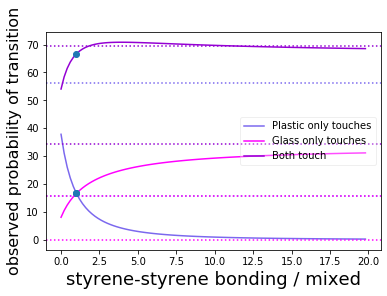

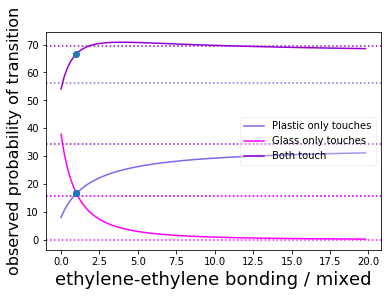

In [20]:

lines =[x1, x2,x3]
#print(lines, np.shape(lines))
eig_plotter(alphas, [[row[beta1] for row in x] for x in lines], cols, 'styrene-styrene bonding / mixed', rsums.T) #using rsum = runs for ranges
eig_plotter(betas, [y[alpha1] for y in lines], cols, 'ethylene-ethylene bonding / mixed', rsums.T) #using rsum = runs for ranges

The proportion of hinge motion varies with different experiments, and there's not a way to know how much hinging vs breaking apart 
takes place, unless there is an independent constraint on the bond strengths. 
This graph shows the flexibility one has in modeling the transitiosn by chosing some linear combination of the break apart and hinging matrices. 

the far left of this graph shows the mixed bond / styrene-styrene bodn inferred if there was only breaking apart, and the far left shows for only hinging. 

In the event of the green line crossing the x axis,as it does here, the bond strength can be as low as you like unless you have other data, but this says tha some breaking apart was definitely occuring (not all hinging).

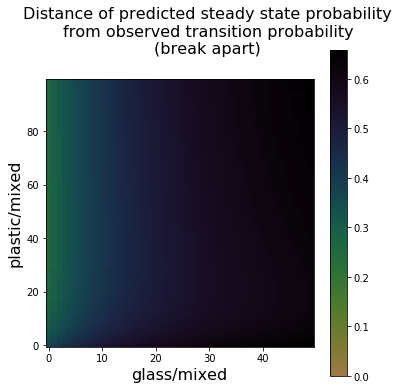

In [21]:

from matplotlib.colors import DivergingNorm
v1,v2,v3=  rsums.T
def mean(li):
    return(sum(li) / len(li))
def rang(li):
    return(abs(max(li)-min(li)))

alphas,betas = np.meshgrid(np.linspace(0,5, 50,endpoint =False),np.linspace(0,10, 100,endpoint =False))
x1 = []
x2 = []
x3 = []
tolerances = [ mean(v1),mean(v2),mean(v3)]
tols = [ rang(v1),rang(v2),rang(v3)]
def distance_from_data(alph,bet):
    i = alph
    j = bet
    T_expected_narrow =np.asarray([[0, 0, 2*(i+1)],
         [0, 0, 2*(j+1)],
                                       [2/(i+1), 2/(1+j), 2]])
    T_expected_broad = T_expected_narrow
    T_expected_broad_norm = np.vstack([T_expected_broad[i]/np.sum(T_expected_broad[i]) for i in range(len(T_expected_broad))])
    #print(T_expected_broad_norm, '\n\n', np.around(T_expected_broad_norm, 2))
    eigvals, eigvecs = np.linalg.eig(T_expected_broad_norm.T)
    eig_one_index = [x for x in range(len(eigvals)) if math.isclose(eigvals[x], 1.0, abs_tol = .0001)][0]
    eigvec_one = eigvecs[:, eig_one_index]
    evec_one = eigvec_one*100 / np.sum(eigvec_one)
        
    return(vector_dist(tolerances, evec_one) / vector_dist(tolerances, [0]*len(tolerances))) #distance between data and model, normalized to the size of the data's value
dfd = np.vectorize(distance_from_data)
dists = dfd(alphas, betas)
fig,ax = plt.subplots(figsize=(6,6))
plt.imshow(dists, cmap="cubehelix_r", norm=DivergingNorm(0)); plt.colorbar()

ax.set_aspect(1./ax.get_data_ratio())
plt.xlabel('glass/mixed', fontsize=16)
plt.ylabel('plastic/mixed', fontsize=16)
fig.suptitle("Distance of predicted steady state probability\nfrom observed transition probability\n(break apart)",fontsize=16)
plt.gca().invert_yaxis()
plt.xticks(np.arange(alphas.shape[1]), alphas.ravel())  # need to set the ticks manually
plt.yticks(np.arange(ys.shape[0]), ys.ravel())


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part


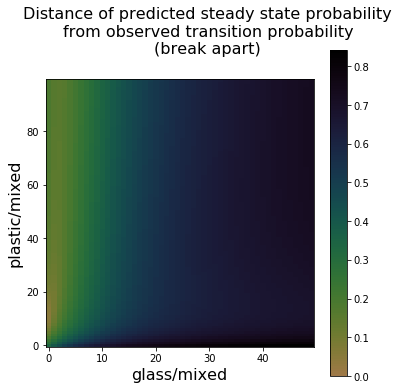

In [22]:

from matplotlib.colors import DivergingNorm
v1,v2,v3=  rsums.T
def mean(li):
    return(sum(li) / len(li))
def rang(li):
    return(abs(max(li)-min(li)))

alphas,betas = np.meshgrid(np.linspace(0,5, 50,endpoint =False),np.linspace(0,10, 100,endpoint =False))
x1 = []
x2 = []
x3 = []
tolerances = [ mean(v1),mean(v2),mean(v3)]
tols = [ rang(v1),rang(v2),rang(v3)]
def distance_from_data(alph,bet):
    i = alph
    j = bet
    p = (j*2/(18*(1+i+j)*(3+i))+
         4*2*(j+1)/(18*2*(3+i)*(1+i+j)*(2+i+j)))
    g = (i*2/(18*(1+i+j)*(3+j))+
         4*2*(i+1)/(18*2*(3+j)*(1+i+j)*(2+i+j)))
    m = (2*j*(i+1)/(18*(3+i)*(1+j+i))+
          8*(i+1)*(j+1)/(18*2*(3+j)*(i+j+1)*(i+j+2))+
          8*(j+1)*(i+1)/(18*2*(3+i)*(i+j+1)*(i+j+2))+
          i*2*(1+j)/(18*(3+j)*(1+i+j)))

    T_expected_narrow = np.asarray([[p, g, m],
                                    [p, g, m],
     [p, g, m]])
    T_expected_broad = T_expected_narrow
    T_expected_broad_norm = np.vstack([T_expected_broad[i]/np.sum(T_expected_broad[i]) for i in range(len(T_expected_broad))])
    #print(T_expected_broad_norm, '\n\n', np.around(T_expected_broad_norm, 2))
    eigvals, eigvecs = np.linalg.eig(T_expected_broad_norm.T)
    eig_one_index = [x for x in range(len(eigvals)) if math.isclose(eigvals[x], 1.0, abs_tol = .0001)][0]
    eigvec_one = eigvecs[:, eig_one_index]
    evec_one = eigvec_one*100 / np.sum(eigvec_one)
        
    return(vector_dist(tolerances, evec_one) / vector_dist(tolerances, [0]*len(tolerances))) #distance between data and model, normalized to the size of the data's value
dfd = np.vectorize(distance_from_data)
dists = dfd(alphas, betas)
fig,ax = plt.subplots(figsize=(6,6))
plt.imshow(dists, cmap="cubehelix_r", norm=DivergingNorm(0)); plt.colorbar()

ax.set_aspect(1./ax.get_data_ratio())
plt.xlabel('glass/mixed', fontsize=16)
plt.ylabel('plastic/mixed', fontsize=16)
fig.suptitle("Distance of predicted steady state probability\nfrom observed transition probability\n(break apart)",fontsize=16)
plt.gca().invert_yaxis()

Now to collect data on the ttransitions times, by run index. 

In [25]:
rtimes = {}
exptnum = 0
bignum = 100
# collect, for each video (in each run), the list of matrices recorded
for ind, expt in enumerate(times.keys()): #per experiment
    exptdicts = times[expt]    
    print('p')
    for runnum, rundict in exptdicts.items(): #the collection of results in a single run of an eperiment
        t_thresh = t_threshes[expt][runnum]
        c_thresh = c_threshes[expt][runnum]
        runkey = (t_thresh, c_thresh) #the trial 
        keys = rundict.keys() # video numbers of run
        for key in keys: #evry video
            if runkey not in rtimes.keys():
                rtimes[runkey] = rundict[key]   
            else:
                rtimes[runkey] = end_append(rtimes[runkey], rundict[key])
    exptnum += bignum
     
#Got to double check!
keys = sorted(rtimes.keys())
for key in keys:
    alltimes = rtimes[key]
    print("\nCollected all transition times for run  {}: \n{}".format(key, alltimes))

And plotting results:

In [24]:
import seaborn
def binnerseq(seq, nbins, discardfrac):
    #control the binning of the output by chunking a portion of it into one big bin at the end
    maximum = np.nanmax([x for y in seq for x in y])
    rang = maximum
    bins = list(np.linspace(0, np.round(maximum/discardfrac), nbins-1))
    #bins.append(maximum) 
    return np.array(bins)



    

timenames = ["Frames between transitions", "Frames stable", "Frames unstable"]
keys = [keys[0]]
for run in keys: 
    times = rtimes[run]
    title = "Run no." + str(run[0]) + "," + str(run[1])
    # for each run, separate the three times
    total_time, stable_time, unstable_time = times
    tind = 1 #only the stable time, please
    print("\nTimes: ")
    for time, timename in zip(times, timenames):
        print(timename)
        time = [[trans for col in row for trans in col] for row in time]
        print('means, ',[np.round(np.nanmean(row)) for row in time])   #This is a pair of means, one for trans from each state  
        print('vars, ',[np.round(np.nanvar(row)) for row in time])
        print(time, '\n')
    time = times[tind]  # choose a time to measure
    time = [[trans for col in row for trans in col] for row in time]
    timename = timenames[tind]
    #times, timenames = times[1:2], timenames[1:2]
    
    
    fig, ax = plt.subplots(figsize = (14, 10)) #All the data
    fig.suptitle(title)   
    ax.set_prop_cycle(color=cols)
    ax.hist(time, bins=binnerseq(time,  60, 1))######
    ax.set_xlabel(timename)
    ax.set_ylabel("Number of videos")
    ax.legend(labels)
    
    fig, ax = plt.subplots(figsize = (14, 10)) #Zoomed in plot
    fig.suptitle(title)   
    ax.set_prop_cycle(color=cols)
    ax.hist(time, bins=binnerseq(time,  60, 6))######
    ax.set_xlabel(timename)
    ax.set_ylabel("Number of videos")
    ax.legend(labels)
    
    
    fig, ax = plt.subplots( figsize = (14, 10))
    fig.suptitle(title)  
    ax.set_prop_cycle(color=cols)
    ax.boxplot(time, labels = labels)####
    ax.set_ylabel(timenames)
    ax.set_xlabel("Type of shape")
    ax.legend(labels)

IndexError: list index out of range

The decay curve is probably because short transitions are being cut off as they are below the current thresholds; the raft evidently isn't always stable for as long as the stability thresholds for these runs.The videos should eb reanalysed with lower thresholds, bearing in mind that there is an error from thresholds which are too low, since the classification does fluctuate especially for active clusters which someimes deviate from a perfect diamond wthout transitioning.

A reason intrinsic to the data why transitiosn might be prferentially short is that short ransitions happen when the raft is full of energy, and when it calms down there are infrequent transitions with long stable times. 
